**Name  : Georgios Hadjiharalambous<br/>
**

In [1]:
!pip3 install ax-platform
!pip install glob
!pip install Augmentor

import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from imageio import imread
import os
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import time
import copy
from IPython.utils import io
import Augmentor
import os
import random
import collections
import glob
from PIL import Image
import PIL
from numpy.random import randint
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import  train, evaluate
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
res_net = models.resnext50_32x4d(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

     |████████████████████████████████| 501kB 37.4MB/s 
     |████████████████████████████████| 225kB 50.2MB/s 
     |████████████████████████████████| 235kB 53.8MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.0.1-py2.py3-none-any.whl size=390441 sha256=5964ba02ebc5ab248cf429ba41ef60ec5b883120d867e2da7cde1a47c04cf970
  Stored in directory: /root/.cache/pip/wheels/10/2f/7a/3328e5713d796daeec2ce8ded141d5f3837253fc3c2a5c62e0
Successfully built gpytorch
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


# Analysis of the problem

In this exercise we will be using a pretrained model of Neural Networks on images for a classification task. Specifically we will be using resnet. This network is pretrained in millions of images and is really deep (i.e it has 50 layers). We will use this model as a significant part of pretraining was done to it and by learning from millions of images, it has already capture many of the features and characteristics that appear on images. Out task is to take this pretrained model and its weights and by freezing its last layer and retrain the weights of that layer specify and train it to classify what we want. This is the general logic behind using pretrained models and the theory called transfer learning. The advantages of using them is that they need less training epochs, time and data. Furthermore, the results we can achieve are astonishing.  <br/> <br/>
The problem we are going to solve is classification of expressions on images of persons. The main emotions a person can have are : Angry, Happy, Surprise, Sad, Disgust, Neutral, Contempt and Fear. As many of the datasets we will be using are not constant on which are the 7 basic expressions and there is a contradiction and absent on Neutral and Contempt, we decided to only use the 6 common on all datasets. For clarity we are repeating the final classes : Angry, Happy, Surprised, Sad, Disgust and Fear.<br/><br/>
This task is particularly challenging as most of the expressions are really hard to understand even for a human being. Furthermore on one part the expression on a person's face is perceived differently by different people (i.e not all people agree on what expression it is). On the opposite corner of the same coin, each person "creating" the expressions thinks different on high exaclty he/she makes that emotion. 
So we can understand it is a very thin and at the same time a bit ambiguous task to classify.
<br/><br/>

Studies have been made [1] and a Facial Action Coding System (FACS) was created to enable to determine the displayed emotion of a human. Above a sample of these codes is shown and also a table of what an emotion must have in order to be considered as that emotion. In the literature, many have tried to "find" or classify the existence of these smaller parts of the expressions in order to finally classify the emotion. None the less, we will be using the images alone to manage and classify the emotion of the person in the image.

Action units that correspond to facial movement. 

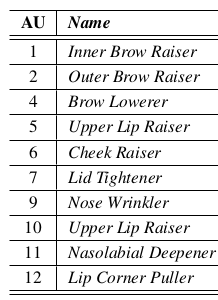


Emotion description in terms of faction action units

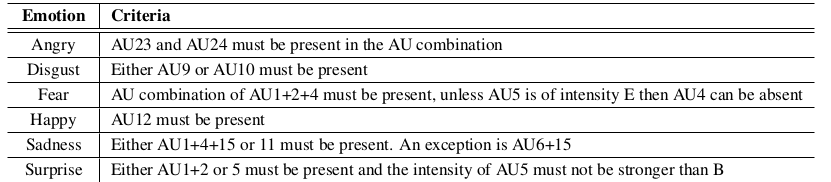


Both of these tables were taken by [2].

In [2]:
number_of_classess=6
!rm -rf data_dl_facial_exressions_ttv_755 #delete any preexisting folder
#the git repository here has many different smaller datasets for the different tests we used and evaluated our system, someone could explore.
!git clone https://gitlab.com/Georgios.Hadjiharalambous/data_dl_facial_exressions_ttv_755 #download out dataset

data_dir="./data_dl_facial_exressions_ttv_755/only_KDEF_Happy/"#2 classes
data_dir="./data_dl_facial_exressions_ttv_755/only_KDEF_3_class/"#3 classes
data_dir="./data_dl_facial_exressions_ttv_755/only_KDEF_fear/"#4 classes
data_dir="./data_dl_facial_exressions_ttv_755/only_KDEF_5_class/"#5 classes
data_dir="./data_dl_facial_exressions_ttv_755/augmented_data/"#augmented_data
data_dir="./data_dl_facial_exressions_ttv_755/ttv_77/"

Cloning into 'data_dl_facial_exressions_ttv_755'...
remote: Enumerating objects: 3273, done.
remote: Counting objects: 100% (3273/3273), done.
remote: Compressing objects: 100% (3256/3256), done.
remote: Total 3273 (delta 36), reused 3253 (delta 16), pack-reused 0
Receiving objects: 100% (3273/3273), 322.03 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Checking out files: 100% (9397/9397), done.


#Visualisation and analysis
Iniatially we created a dataset combined out of two smaller datasets. The reason why we did not keep this dataset, is that the dataset images were too small. More specifically, the size of an image was 48-48 pixels. This was a big drawback as the image quality was not really good. For this reason when an image was used for training in the Resnet model the results were not good. As the pretrained model needs an input size of 224-224 we need to add something like zero padding to make our images match the dimensions of input of our model. The pretrained network, is able to work well given the assumption of a relatively high quality image is used as input. Since we provide inputs of small size/quality it is not able to recognize the associated features and extract the correspondint knowledge from them. As a consequence those results were not really good. In this case, we would not be able to make good use of the pretrained model and it would need a lot of iterations to learn the correct features and if it finally managed to learn them. That's why we created a new dataset with a larger image size.
<br/> <br/>
Our new dataset consists of 3 smaller datasets. These are : Cohn-Kanade, The Japanese Female Facial Expression (JAFFE) Database and Karolinska Directed Emotional Faces database (KDEF). Some images could have been used from the Yale Face Databasebut.None the less as it only contain some of the classes (which were the most frequent ones) we decided currently not to use them. All of the above mentioned datasets have images size bigger than the minimum needed for our pretrained model. The sizes are : 640-490, 256-256 and 562-762 respectively. The dataset containes both gray-scale images and colourful. 
Below we provide a sample of the images contained in our final dataset. 


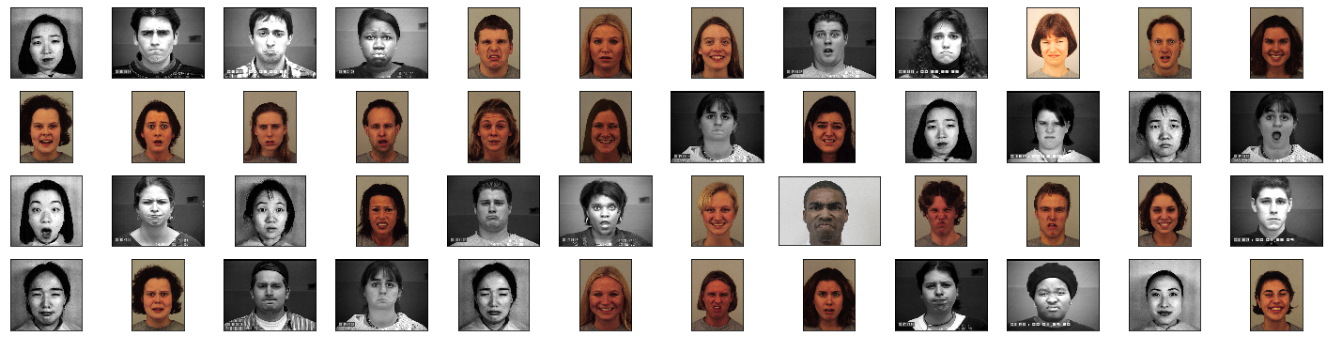

In order to make our dataset noise resistant and fault tolerant we added data augmentation. Data augmentation is also helpful if we want to increase the size of our dataset and introduce variability to it. We can do data augmentation by applying many transformations to the images of a dataset. Such transformations are rotations, zooming, cropping, rescaling, flipping and others. Currently we are only applying random cropping and random flipping as we don't want to make the problem too hard.

Since we are the ones that separated the images initially, the data distribution is well balanced. For each class we have about the same percentage in the dataset and that is around 17%. Furthermore for the same reason we have to say that the split ratio for train, test and validation is 0.7,0.15, 0.15. Also as this was done using python (locally) we used a random number generator to utilise the train, test, validation ratio. We also tried to achieve variability to all of these 3 smaller datasets and keep at the same time the classes well balanced with the help of the random number generator. The class distribution for all three parts of the dataset are shown above.

Distribution for classes in train
class Sad has percentage =	 0.154420
class Surprise has percentage =	 0.176784
class Disgust has percentage =	 0.171459
class Happy has percentage =	 0.187433
class Angry has percentage =	 0.168264
class Fear has percentage =	 0.141640


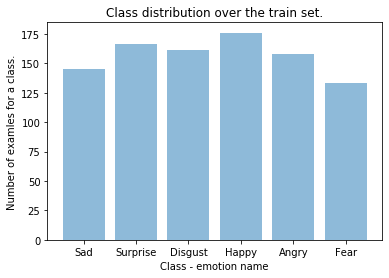

In [0]:
class_distribution={}
#Get the folder of the dataset and count the distribution of the classes for the train set.
with io.capture_output() as captured:
  for fold in ['train']:#['test','train','validation']:
    folders = []
    root_directory=data_dir+fold+"/*"
    for f in glob.glob(root_directory):
        if os.path.isdir(f):
            folders.append(os.path.abspath(f))
    pipelines = {}
    for folder in folders:
        pipelines[os.path.split(folder)[1]] = (Augmentor.Pipeline(folder));
    class_distr={}
    for p in pipelines.values():
        class_distr[p.augmentor_images[0].class_label]=len(p.augmentor_images)   ;    
    class_distribution[fold]=class_distr

  !rm -rf data_dl_facial_exressions_ttv_755
  !git clone https://gitlab.com/Georgios.Hadjiharalambous/data_dl_facial_exressions_ttv_755     

for k in class_distribution:
  v=class_distribution[k]
  s=sum(v.values())
  #print("-"*10)  
  print("Distribution for classes in %s"%k)
  for kk in v:
    print("class %s has percentage =\t %3f"%(kk,(v[kk]/s)))

#plotting bar chart for the class distribution
y_pos = np.arange(len(class_distribution['train']))
plt.bar(y_pos, class_distribution['train'].values(), align='center', alpha=0.5)
plt.xticks(y_pos, class_distribution['train'].keys())
plt.ylabel('Number of examles for a class.')
plt.xlabel("Class - emotion name")
plt.title('Class distribution over the train set.')
plt.show()  

In [3]:
#This notebook and code is based on [3] which we took many parts of our code, especially concerning the pretrained model.
batch_size=32
input_size=224 #as specified by both Resnet and Vgg
#Here we create our dataloader, data tranformations and data augmentation
#For augmentation we are using random cropping of the image and random flipping of the image.
#Also we tried to use gray scale images to check if it gives any improvement in our accuracy compared to RGB images.
#In order to do that we fed a gray scale image, 3 times into the RGB as our model uses RBG as its input.
data_transforms = {
    'train': transforms.Compose([
        #transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(input_size,scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
       #transforms.Lambda(lambda xx:xx.view(1,input_size, input_size).expand(3,-1, -1)),#to make the gray scale image back to RGB like to fit the model
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Grayscale(num_output_channels=1),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #transforms.Lambda(lambda xx:xx.view(1,input_size, input_size).expand(3,-1, -1)),#to make the gray scale image back to RGB like to fit the model
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        #transforms.Grayscale(num_output_channels=1),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #transforms.Lambda(lambda xx:xx.view(1,input_size, input_size).expand(3,-1, -1)),#to make the gray scale image back to RGB like to fit the model
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
print("Initializing Datasets and Dataloaders...")
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test','validation']}
# Create training and validation dataloaders

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test','validation']}
# Detect if we have a GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


Initializing Datasets and Dataloaders...


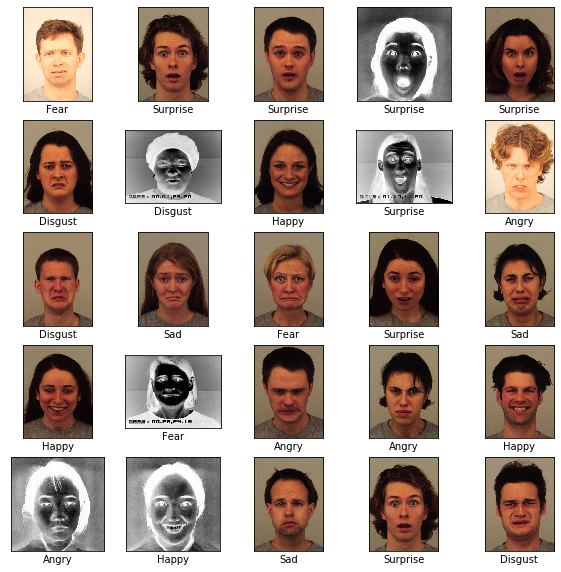

In [0]:
#Here we show some images from our dataset and their correspond label.
plt.figure(figsize=(10,10))
train_images=dataloaders_dict['test'].dataset.imgs
dict_lab=dataloaders_dict['test'].dataset.class_to_idx
dict_labels={dict_lab[k]:k for k in dict_lab}
index = randint(0, len(train_images), 25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.asarray(PIL.Image.open(train_images[index[i]][0])), cmap=plt.cm.binary)
    plt.xlabel(dict_labels[train_images[index[i]][1]])
plt.show()


The KDEF dataset had images that were captured from different angles. In our main dataset we used only images taken at right angle from the camera. As an extra experiment we tried to use also images taken from 45 degrees angle from the camera. Altough this is not exaclty data augmentation, it can act similar to that as at least half of the person's face is visible and some distortion is added compared to the full face images. This could be used to further fine tune our models to recognize only the correct parts of the images necessary for classification. When evaluated this, the results we got were not as good as without this augmentation so for the final results we removed it.


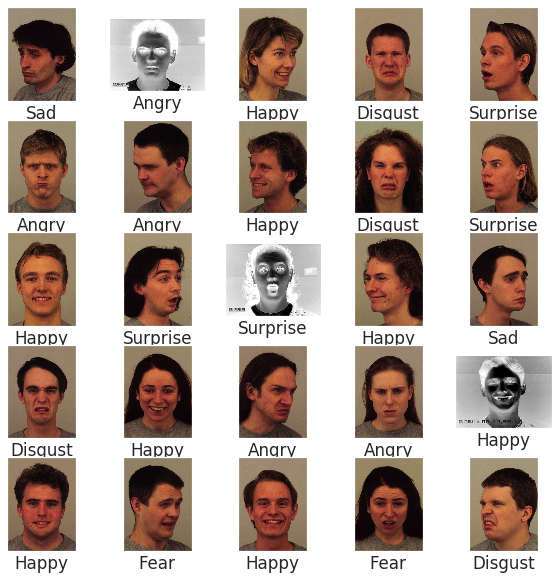

#Multiple candidate network architectures
Initially we build both a Logistic Regression (LR) classifier and a simple two layer dense neural network to work as our more complex baseline method and compare the results. While training both of these we have seen that really none of them was learning anything, so for the fine tuning part we decided only to keep the Neural network as it is more complex, and theoritcailly could hold more expressive power to capture the images distribution.
<br/>
**The main reason behinds this learning inability is the low number of data images we have. For each class we have about 160 images. For a neural network to learn well to classify especially images it needs hundred thousands examples.**

**It is expected that these two models would not have good accuracy scores. Some reasons which are valid in general even if the above contitions are met are their small complexity (mainly LR) and the absent of filters similar to that of convolutional networks. This is where the power and usefulness of pretrained models is really shown. By just using the pretrained network and a simple connected output layer we can have many times better accuracy than by training a simpler neural network from scratch.**


In this part we define the model training function (train_model) that is used to train the model and at the same time evalute it using the validation set, needed for the fine tuning part. Also we define a minor early stopping trick (as a heuristic) to stop the training loop when for three consecutive epochs the validation loss increases. This acts as a stopping criteria when our model is moving away from the solution. We also created a function (get_results) that takes a trained model and a dataset as input and returns the results of the predictions and different metrics such as loss and accuracy. It is mainly used to evaluate the trained model with the test set.

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,phases=['train', 'validation']):
    since = time.time()
    model=model.to(device)
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping=0
    prev_val_loss=0
    for epoch in range(num_epochs):
        t=time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in phases:
            if (phase == 'train' or phase=='train_validation'):
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                #this is used to change the behaviour of some layers e.g for a Dropout Layer if in evaluating mode, not to drop any neurons.
                #information taken by https://discuss.pytorch.org/t/confused-about-set-grad-enabled/38417
                with torch.set_grad_enabled(phase == 'train' or phase=='train_validation'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  _, preds = torch.max(outputs, 1)#get the corresponding label for the class with the highest probability 
                 

                  # calculate the loss gradients and update the weights of the model corresponding to that loss
                  if (phase == 'train' or phase=='train_validation'):
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if(len(phases)==1 and (phases[0]=='train' or phase=='train_validation' )):
              val_acc_history.append(get_results(model,dataloaders_dict['validation'])['epoch_acc'])

            # deep copy the model
            if (phase == 'validation' or phase == 'test') and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())#keep the best model found until now.
            if (phase == 'validation' or phase == 'test'):
                if(prev_val_loss<epoch_loss):#early stropping if not improvement is made to valid. data
                  prev_val_loss=epoch_loss
                  early_stopping+=1
                else:
                  early_stopping=0
                  prev_val_loss=epoch_loss
                if(early_stopping==3):
                  return {"epoch_acc":(epoch_acc,0)}  
                val_acc_history.append(epoch_acc)
        print('Time needed for one epoch : ',t-time.time())
        print()
    if(len(phases)==1 and (phases[0]=='train' or phase=='train_validation')):
      # load best model weights
      #model.load_state_dict(best_model_wts)
      return (model,val_acc_history)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))    
    return  {"epoch_acc":(epoch_acc,0)} #this return is used for the Bayesian optimization framework (AX)

In [0]:
def get_results(model,data):
    model=model.to(device)
    best_acc = 0.0
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    predictions=[]
    # Iterate over data.
    index_p=0
    index_la=0
    pre=np.zeros(len(data.dataset.imgs))
    lab=np.zeros(len(data.dataset.imgs))

    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        for p in preds:
          pre[index_p]=p.item()
          index_p+=1
        for l in labels.data:
          lab[index_la]=l.item()  
          index_la+=1


        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data.dataset)
    epoch_acc = running_corrects.double() / len(data.dataset)
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))   
    return  {"epoch_acc":epoch_acc,"epoch_loss":epoch_loss,"running_corrects":running_corrects,"predictions":pre,"labels":lab} 

In [0]:
#Here we implement a baseline model.
#This model is a neural network with one hidden layer with 250 neurons.

channel_in=3
D_in=input_size
D_out=number_of_classess
H=250#number of hidden units
model_NN_dense = nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D_in**2*channel_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H,D_out),
    )

#Training
In this part we are doing the fine tuning of the parameters using hyperparameter search. More specifically instead of using a method like grid search or random search, we decided to use Bayesian optimization to find the best parameters for our 3 models. We want to optimize learning rate, momentum and weight decay. This method uses sampling to assess the input space and find where the high probability - high value parameters exist. Then when done enought sampling it tunes the hyperparameters accordingly.  As a regularization method we use weight decay. We have seen that our model overfits at some point to the data and by applying regularization we try to penalize the weights - parameters for overfitting. Weight decay parameter is equal to L2 regularization. Futhermore, we used different nunber of epochs for training to let each specific model get trained enought. This was done by using small and big numbers until we found a good range of epochs to use. The loss function we used was CrossEntropyLoss. The metric for evaluating the model quality was classification accuracy and it was the value returned by the objective function of the AX framework - bayesian optimization.

In [0]:
#In this loop we define the Bayesian optimization to find the best parameters for all of our models.
stats={}
for model_used in [res_net,model_NN_dense,vgg16]:
  print("Model fine tuned with Bayesian optimization is ",model_used.__class__.__name__)
  def train_and_tune(parameterization):
    global model_used
    phases=['train','validation']
    weight_decay=parameterization['weight_decay']
    learning_rate=parameterization['lr']
    momentum=parameterization['momentum']
    for param in model_used.parameters():    
      param.requires_grad = False

    flag=False 
      #unfreeze only the last layer of the pretrained models in order to train it
    if('VGG'==model_used.__class__.__name__):
      flag=True
      model_used.classifier[6]=nn.Linear(in_features=4096, out_features=number_of_classess, bias=True)
    elif ('ResNet'==model_used.__class__.__name__):
      model_used.fc=nn.Linear(in_features=2048, out_features=number_of_classess, bias=True)
      flag=True
         
    #find the parameters (weights) that reaquire training
    print(flag)
    if(flag):
      params_to_update = []
      for name,param in model_used.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
      optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum,weight_decay=weight_decay)    
    else :
      model_NN_dense = nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D_in**2*channel_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H,D_out),
    )
      optimizer_ft = optim.SGD(model_NN_dense.parameters(), lr=learning_rate, momentum=momentum,weight_decay=weight_decay)
      model_used=model_NN_dense
    
    
    print('lr=',parameterization['lr'],' mom=',parameterization['momentum'],'weight_decay',weight_decay)

    num_epochs=17
    return train_model(model_used, dataloaders_dict, criterion, optimizer_ft, num_epochs,phases)

  stats[model_used.__class__.__name__]= optimize(
      parameters=[
          {"name": "lr", "type": "range", "bounds": [1e-3, 0.4], "log_scale": True},
          {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
          {"name": "weight_decay","type":"range", "bounds": [0.0, 1.0]},          
                ], evaluation_function=train_and_tune,objective_name='epoch_acc',)

[INFO 03-09 09:37:50] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 09:37:50] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 09:37:50] ax.service.managed_loop: Running optimization trial 1...


Model fine tuned with Bayesian optimization is  ResNet
True
lr= 0.031674040155595835  mom= 0.1555119901895523 weight_decay 0.3874090611934662
Epoch 0/16
----------
train Loss: 2.0619 Acc: 0.2439
validation Loss: 1.8901 Acc: 0.2564
Time needed for one epoch :  -9.998475551605225

Epoch 1/16
----------
train Loss: 2.0225 Acc: 0.3259
validation Loss: 1.7899 Acc: 0.3692
Time needed for one epoch :  -9.88656234741211

Epoch 2/16
----------
train Loss: 1.8098 Acc: 0.3429
validation Loss: 1.3612 Acc: 0.5231
Time needed for one epoch :  -9.711681604385376

Epoch 3/16
----------
train Loss: 1.6787 Acc: 0.3972
validation Loss: 1.2429 Acc: 0.5333
Time needed for one epoch :  -9.76907205581665

Epoch 4/16
----------
train Loss: 1.6282 Acc: 0.4015
validation Loss: 1.8786 Acc: 0.3846
Time needed for one epoch :  -9.57486629486084

Epoch 5/16
----------
train Loss: 1.6910 Acc: 0.3994
validation Loss: 2.2455 Acc: 0.2000
Time needed for one epoch :  -9.577604532241821

Epoch 6/16
----------
train Loss:

[INFO 03-09 09:40:46] ax.service.managed_loop: Running optimization trial 2...


validation Loss: 2.3829 Acc: 0.4000
Time needed for one epoch :  -9.744194507598877

Training complete in 2m 56s
Best val Acc: 0.569231
True
lr= 0.0019849677761934323  mom= 0.7297206521034241 weight_decay 0.9067041873931885
Epoch 0/16
----------
train Loss: 1.7556 Acc: 0.2577
validation Loss: 1.6589 Acc: 0.2769
Time needed for one epoch :  -9.900798797607422

Epoch 1/16
----------
train Loss: 1.6218 Acc: 0.3972
validation Loss: 1.5930 Acc: 0.3692
Time needed for one epoch :  -9.666264295578003

Epoch 2/16
----------
train Loss: 1.5540 Acc: 0.3994
validation Loss: 1.4539 Acc: 0.5744
Time needed for one epoch :  -9.832437753677368

Epoch 3/16
----------
train Loss: 1.4759 Acc: 0.5240
validation Loss: 1.4295 Acc: 0.5590
Time needed for one epoch :  -9.80799150466919

Epoch 4/16
----------
train Loss: 1.4472 Acc: 0.5751
validation Loss: 1.4056 Acc: 0.5538
Time needed for one epoch :  -9.835710525512695

Epoch 5/16
----------
train Loss: 1.4142 Acc: 0.5421
validation Loss: 1.3672 Acc: 0.635

[INFO 03-09 09:43:32] ax.service.managed_loop: Running optimization trial 3...


validation Loss: 1.2992 Acc: 0.6410
Time needed for one epoch :  -9.6451575756073

Training complete in 2m 46s
Best val Acc: 0.641026
True
lr= 0.004679547125528292  mom= 0.13791002333164215 weight_decay 0.5997076630592346
Epoch 0/16
----------
train Loss: 1.7806 Acc: 0.2173
validation Loss: 1.6491 Acc: 0.3744
Time needed for one epoch :  -9.509536504745483

Epoch 1/16
----------
train Loss: 1.6622 Acc: 0.3450
validation Loss: 1.5485 Acc: 0.5282
Time needed for one epoch :  -9.41222357749939

Epoch 2/16
----------
train Loss: 1.5877 Acc: 0.4153
validation Loss: 1.5064 Acc: 0.5026
Time needed for one epoch :  -9.43741750717163

Epoch 3/16
----------
train Loss: 1.5313 Acc: 0.4728
validation Loss: 1.4420 Acc: 0.4769
Time needed for one epoch :  -9.549006223678589

Epoch 4/16
----------
train Loss: 1.4790 Acc: 0.4995
validation Loss: 1.4059 Acc: 0.5590
Time needed for one epoch :  -9.45195984840393

Epoch 5/16
----------
train Loss: 1.4224 Acc: 0.5548
validation Loss: 1.4620 Acc: 0.4615
Ti

[INFO 03-09 09:46:13] ax.service.managed_loop: Running optimization trial 4...


validation Loss: 1.2267 Acc: 0.6205
Time needed for one epoch :  -9.463442325592041

Training complete in 2m 41s
Best val Acc: 0.641026
True
lr= 0.004059041152408484  mom= 0.43346020579338074 weight_decay 0.1665024608373642
Epoch 0/16
----------
train Loss: 1.7604 Acc: 0.2716
validation Loss: 1.6304 Acc: 0.4410
Time needed for one epoch :  -9.47475552558899

Epoch 1/16
----------
train Loss: 1.6187 Acc: 0.3717
validation Loss: 1.5136 Acc: 0.4667
Time needed for one epoch :  -9.376551151275635

Epoch 2/16
----------
train Loss: 1.5036 Acc: 0.4814
validation Loss: 1.4621 Acc: 0.4718
Time needed for one epoch :  -9.482245445251465

Epoch 3/16
----------
train Loss: 1.4283 Acc: 0.5229
validation Loss: 1.3454 Acc: 0.5231
Time needed for one epoch :  -9.512786865234375

Epoch 4/16
----------
train Loss: 1.3659 Acc: 0.5644
validation Loss: 1.2877 Acc: 0.5692
Time needed for one epoch :  -9.44771432876587

Epoch 5/16
----------
train Loss: 1.3164 Acc: 0.5879
validation Loss: 1.2537 Acc: 0.5795

[INFO 03-09 09:48:54] ax.service.managed_loop: Running optimization trial 5...


validation Loss: 1.0639 Acc: 0.6308
Time needed for one epoch :  -9.538109302520752

Training complete in 2m 41s
Best val Acc: 0.661538
True
lr= 0.1359565803815992  mom= 0.6989878416061401 weight_decay 0.9013116359710693
Epoch 0/16
----------
train Loss: 25.5749 Acc: 0.1981
validation Loss: 45.9201 Acc: 0.1282
Time needed for one epoch :  -9.488322257995605

Epoch 1/16
----------
train Loss: 29.1905 Acc: 0.1842
validation Loss: 20.9394 Acc: 0.1282
Time needed for one epoch :  -9.352774858474731

Epoch 2/16
----------
train Loss: 31.7965 Acc: 0.1768
validation Loss: 42.4077 Acc: 0.1436
Time needed for one epoch :  -9.436855554580688

Epoch 3/16
----------
train Loss: 31.3047 Acc: 0.1874
validation Loss: 39.8801 Acc: 0.2462
Time needed for one epoch :  -9.419968366622925

Epoch 4/16
----------
train Loss: 32.1380 Acc: 0.1608
validation Loss: 12.6297 Acc: 0.2513
Time needed for one epoch :  -9.464874505996704

Epoch 5/16
----------
train Loss: 30.4659 Acc: 0.1768
validation Loss: 15.0307 

[INFO 03-09 09:50:38] ax.service.managed_loop: Running optimization trial 6...


validation Loss: 30.2141 Acc: 0.1795
True
lr= 0.001734419212762253  mom= 0.4656272496133702 weight_decay 0.5585797014466714
Epoch 0/16
----------
train Loss: 1.7796 Acc: 0.2311
validation Loss: 1.7108 Acc: 0.2769
Time needed for one epoch :  -9.418468713760376

Epoch 1/16
----------
train Loss: 1.6988 Acc: 0.3248
validation Loss: 1.6311 Acc: 0.4000
Time needed for one epoch :  -9.683643341064453

Epoch 2/16
----------
train Loss: 1.6376 Acc: 0.4164
validation Loss: 1.5828 Acc: 0.4974
Time needed for one epoch :  -9.469654083251953

Epoch 3/16
----------
train Loss: 1.5932 Acc: 0.4558
validation Loss: 1.5049 Acc: 0.5897
Time needed for one epoch :  -9.456495761871338

Epoch 4/16
----------
train Loss: 1.5430 Acc: 0.4973
validation Loss: 1.4721 Acc: 0.5590
Time needed for one epoch :  -9.425625324249268

Epoch 5/16
----------
train Loss: 1.5111 Acc: 0.5016
validation Loss: 1.4428 Acc: 0.6051
Time needed for one epoch :  -9.529164791107178

Epoch 6/16
----------
train Loss: 1.4741 Acc: 0.

[INFO 03-09 09:53:20] ax.service.managed_loop: Running optimization trial 7...


validation Loss: 1.2912 Acc: 0.5897
Time needed for one epoch :  -9.312138080596924

Training complete in 2m 41s
Best val Acc: 0.651282
True
lr= 0.0029074248509963294  mom= 0.3992375604306401 weight_decay 1.0
Epoch 0/16
----------
train Loss: 1.7745 Acc: 0.2226
validation Loss: 1.7160 Acc: 0.3333
Time needed for one epoch :  -9.450720310211182

Epoch 1/16
----------
train Loss: 1.6770 Acc: 0.3525
validation Loss: 1.6027 Acc: 0.4667
Time needed for one epoch :  -9.337276220321655

Epoch 2/16
----------
train Loss: 1.5994 Acc: 0.4345
validation Loss: 1.5718 Acc: 0.4000
Time needed for one epoch :  -9.426406145095825

Epoch 3/16
----------
train Loss: 1.5609 Acc: 0.4409
validation Loss: 1.4917 Acc: 0.5795
Time needed for one epoch :  -9.411857843399048

Epoch 4/16
----------
train Loss: 1.5208 Acc: 0.5027
validation Loss: 1.4738 Acc: 0.5231
Time needed for one epoch :  -9.302919149398804

Epoch 5/16
----------
train Loss: 1.4788 Acc: 0.5282
validation Loss: 1.4548 Acc: 0.5487
Time needed 

[INFO 03-09 09:56:00] ax.service.managed_loop: Running optimization trial 8...


validation Loss: 1.3395 Acc: 0.6308
Time needed for one epoch :  -9.413750410079956

Training complete in 2m 40s
Best val Acc: 0.630769
True
lr= 0.004593907305699282  mom= 0.6449403978308407 weight_decay 0.6819405765214834
Epoch 0/16
----------
train Loss: 1.7337 Acc: 0.2609
validation Loss: 1.5467 Acc: 0.3949
Time needed for one epoch :  -9.376837968826294

Epoch 1/16
----------
train Loss: 1.5504 Acc: 0.4601
validation Loss: 1.4064 Acc: 0.5538
Time needed for one epoch :  -9.346745491027832

Epoch 2/16
----------
train Loss: 1.4488 Acc: 0.5037
validation Loss: 1.3647 Acc: 0.5795
Time needed for one epoch :  -9.374341487884521

Epoch 3/16
----------
train Loss: 1.4015 Acc: 0.5133
validation Loss: 1.3360 Acc: 0.5846
Time needed for one epoch :  -9.431746482849121

Epoch 4/16
----------
train Loss: 1.3607 Acc: 0.5538
validation Loss: 1.2934 Acc: 0.5897
Time needed for one epoch :  -9.426574468612671

Epoch 5/16
----------
train Loss: 1.3394 Acc: 0.5463
validation Loss: 1.3722 Acc: 0.523

[INFO 03-09 09:58:42] ax.service.managed_loop: Running optimization trial 9...


validation Loss: 1.2682 Acc: 0.6051
Time needed for one epoch :  -9.357096195220947

Training complete in 2m 41s
Best val Acc: 0.625641
True
lr= 0.0030424715083058867  mom= 3.630212465297084e-16 weight_decay 0.039958752549835566
Epoch 0/16
----------
train Loss: 1.7876 Acc: 0.2162
validation Loss: 1.6974 Acc: 0.3538
Time needed for one epoch :  -9.304267644882202

Epoch 1/16
----------
train Loss: 1.7143 Acc: 0.3152
validation Loss: 1.6196 Acc: 0.4256
Time needed for one epoch :  -9.421995639801025

Epoch 2/16
----------
train Loss: 1.6401 Acc: 0.4196
validation Loss: 1.5699 Acc: 0.4769
Time needed for one epoch :  -9.342822790145874

Epoch 3/16
----------
train Loss: 1.5898 Acc: 0.4452
validation Loss: 1.5332 Acc: 0.4462
Time needed for one epoch :  -9.448209762573242

Epoch 4/16
----------
train Loss: 1.5327 Acc: 0.5091
validation Loss: 1.4643 Acc: 0.5590
Time needed for one epoch :  -9.382486820220947

Epoch 5/16
----------
train Loss: 1.4967 Acc: 0.5229
validation Loss: 1.4372 Acc:

[INFO 03-09 10:01:23] ax.service.managed_loop: Running optimization trial 10...


validation Loss: 1.1751 Acc: 0.6000
Time needed for one epoch :  -9.383849143981934

Training complete in 2m 40s
Best val Acc: 0.661538
True
lr= 0.0010000000000011308  mom= 1.0 weight_decay 0.9999999999998732
Epoch 0/16
----------
train Loss: 1.7608 Acc: 0.2226
validation Loss: 1.5170 Acc: 0.4615
Time needed for one epoch :  -9.43104076385498

Epoch 1/16
----------
train Loss: 1.4065 Acc: 0.4782
validation Loss: 1.2052 Acc: 0.6000
Time needed for one epoch :  -9.462701559066772

Epoch 2/16
----------
train Loss: 1.2321 Acc: 0.5495
validation Loss: 1.2515 Acc: 0.5795
Time needed for one epoch :  -9.269867420196533

Epoch 3/16
----------
train Loss: 1.3531 Acc: 0.4792
validation Loss: 1.6957 Acc: 0.2410
Time needed for one epoch :  -9.340914011001587

Epoch 4/16
----------
train Loss: 1.7925 Acc: 0.2982


[INFO 03-09 10:02:10] ax.service.managed_loop: Running optimization trial 11...


validation Loss: 2.1757 Acc: 0.1744
True
lr= 0.0023479935202231064  mom= 0.6052394746486753 weight_decay 1.0
Epoch 0/16
----------
train Loss: 1.7718 Acc: 0.2354
validation Loss: 1.6727 Acc: 0.3897
Time needed for one epoch :  -9.421950578689575

Epoch 1/16
----------
train Loss: 1.6465 Acc: 0.3887
validation Loss: 1.5522 Acc: 0.5538
Time needed for one epoch :  -9.407738208770752

Epoch 2/16
----------
train Loss: 1.5740 Acc: 0.4537
validation Loss: 1.5399 Acc: 0.4410
Time needed for one epoch :  -10.048902988433838

Epoch 3/16
----------
train Loss: 1.5245 Acc: 0.4963
validation Loss: 1.4777 Acc: 0.4205
Time needed for one epoch :  -9.953897953033447

Epoch 4/16
----------
train Loss: 1.4829 Acc: 0.5080
validation Loss: 1.4115 Acc: 0.6051
Time needed for one epoch :  -10.054420471191406

Epoch 5/16
----------
train Loss: 1.4595 Acc: 0.5570
validation Loss: 1.4097 Acc: 0.5487
Time needed for one epoch :  -9.351978778839111

Epoch 6/16
----------
train Loss: 1.4336 Acc: 0.5538
validati

[INFO 03-09 10:04:53] ax.service.managed_loop: Running optimization trial 12...


validation Loss: 1.3575 Acc: 0.5897
Time needed for one epoch :  -9.366560935974121

Training complete in 2m 42s
Best val Acc: 0.651282
True
lr= 0.00258009858126689  mom= 0.24038614006292874 weight_decay 0.29684636588305896
Epoch 0/16
----------
train Loss: 1.7646 Acc: 0.2439
validation Loss: 1.6881 Acc: 0.3795
Time needed for one epoch :  -9.506551742553711

Epoch 1/16
----------
train Loss: 1.6974 Acc: 0.3120
validation Loss: 1.6060 Acc: 0.5077
Time needed for one epoch :  -9.439766883850098

Epoch 2/16
----------
train Loss: 1.6234 Acc: 0.4356
validation Loss: 1.5549 Acc: 0.4667
Time needed for one epoch :  -9.369357824325562

Epoch 3/16
----------
train Loss: 1.5700 Acc: 0.4462
validation Loss: 1.5084 Acc: 0.5282
Time needed for one epoch :  -9.373476505279541

Epoch 4/16
----------
train Loss: 1.5232 Acc: 0.4920
validation Loss: 1.4506 Acc: 0.5487
Time needed for one epoch :  -9.413804054260254

Epoch 5/16
----------
train Loss: 1.4781 Acc: 0.5176
validation Loss: 1.4208 Acc: 0.60

[INFO 03-09 10:07:34] ax.service.managed_loop: Running optimization trial 13...


validation Loss: 1.2090 Acc: 0.6513
Time needed for one epoch :  -9.412422895431519

Training complete in 2m 40s
Best val Acc: 0.676923
True
lr= 0.004177334606057891  mom= 0.3227311573876378 weight_decay 0.6057284717045677
Epoch 0/16
----------
train Loss: 1.7782 Acc: 0.2077
validation Loss: 1.6852 Acc: 0.3282
Time needed for one epoch :  -9.515867233276367

Epoch 1/16
----------
train Loss: 1.6485 Acc: 0.3695
validation Loss: 1.6283 Acc: 0.2769
Time needed for one epoch :  -9.307836532592773

Epoch 2/16
----------
train Loss: 1.5677 Acc: 0.4398
validation Loss: 1.4753 Acc: 0.5949
Time needed for one epoch :  -9.27290678024292

Epoch 3/16
----------
train Loss: 1.4824 Acc: 0.4909
validation Loss: 1.4816 Acc: 0.5179
Time needed for one epoch :  -9.366838693618774

Epoch 4/16
----------
train Loss: 1.4325 Acc: 0.5634
validation Loss: 1.3737 Acc: 0.5897
Time needed for one epoch :  -9.38457202911377

Epoch 5/16
----------
train Loss: 1.3886 Acc: 0.5740
validation Loss: 1.3381 Acc: 0.6051


[INFO 03-09 10:10:15] ax.service.managed_loop: Running optimization trial 14...


validation Loss: 1.2557 Acc: 0.5538
Time needed for one epoch :  -9.400192737579346

Training complete in 2m 40s
Best val Acc: 0.646154
True
lr= 0.001200690675735066  mom= 0.08518022380159518 weight_decay 0.5424391584952754
Epoch 0/16
----------
train Loss: 1.8205 Acc: 0.1555
validation Loss: 1.7609 Acc: 0.2205
Time needed for one epoch :  -9.426880121231079

Epoch 1/16
----------
train Loss: 1.7842 Acc: 0.2300
validation Loss: 1.7428 Acc: 0.2821
Time needed for one epoch :  -9.461822509765625

Epoch 2/16
----------
train Loss: 1.7392 Acc: 0.2939
validation Loss: 1.7025 Acc: 0.3436
Time needed for one epoch :  -9.54182481765747

Epoch 3/16
----------
train Loss: 1.7145 Acc: 0.3344
validation Loss: 1.6755 Acc: 0.4051
Time needed for one epoch :  -9.441931009292603

Epoch 4/16
----------
train Loss: 1.6852 Acc: 0.3706
validation Loss: 1.6334 Acc: 0.4256
Time needed for one epoch :  -9.357595682144165

Epoch 5/16
----------
train Loss: 1.6599 Acc: 0.4175
validation Loss: 1.6219 Acc: 0.425

[INFO 03-09 10:12:56] ax.service.managed_loop: Running optimization trial 15...


validation Loss: 1.4277 Acc: 0.6154
Time needed for one epoch :  -9.396568775177002

Training complete in 2m 41s
Best val Acc: 0.615385
True
lr= 0.0014467705385865332  mom= 0.30243004142789476 weight_decay 2.281488208065382e-16
Epoch 0/16
----------
train Loss: 1.7760 Acc: 0.2375
validation Loss: 1.7426 Acc: 0.2974
Time needed for one epoch :  -9.62895131111145

Epoch 1/16
----------
train Loss: 1.7286 Acc: 0.3099
validation Loss: 1.6931 Acc: 0.3897
Time needed for one epoch :  -9.338439464569092

Epoch 2/16
----------
train Loss: 1.6806 Acc: 0.3621
validation Loss: 1.6510 Acc: 0.4154
Time needed for one epoch :  -9.467910766601562

Epoch 3/16
----------
train Loss: 1.6347 Acc: 0.4260
validation Loss: 1.6266 Acc: 0.3846
Time needed for one epoch :  -9.351609230041504

Epoch 4/16
----------
train Loss: 1.5964 Acc: 0.4633
validation Loss: 1.5676 Acc: 0.4872
Time needed for one epoch :  -9.473999977111816

Epoch 5/16
----------
train Loss: 1.5618 Acc: 0.4707
validation Loss: 1.5123 Acc: 0

[INFO 03-09 10:15:37] ax.service.managed_loop: Running optimization trial 16...


validation Loss: 1.2767 Acc: 0.5795
Time needed for one epoch :  -9.396318197250366

Training complete in 2m 40s
Best val Acc: 0.594872
True
lr= 0.001535380179955435  mom= 0.6912179276919653 weight_decay 0.6037151723668547
Epoch 0/16
----------
train Loss: 1.7858 Acc: 0.2077
validation Loss: 1.7132 Acc: 0.2923
Time needed for one epoch :  -9.531267642974854

Epoch 1/16
----------
train Loss: 1.6787 Acc: 0.3376
validation Loss: 1.6124 Acc: 0.4103
Time needed for one epoch :  -9.377691745758057

Epoch 2/16
----------
train Loss: 1.5939 Acc: 0.4292
validation Loss: 1.5167 Acc: 0.4923
Time needed for one epoch :  -9.316439628601074

Epoch 3/16
----------
train Loss: 1.5233 Acc: 0.5091
validation Loss: 1.4805 Acc: 0.5436
Time needed for one epoch :  -9.340585470199585

Epoch 4/16
----------
train Loss: 1.4822 Acc: 0.5165
validation Loss: 1.4148 Acc: 0.5692
Time needed for one epoch :  -9.325708866119385

Epoch 5/16
----------
train Loss: 1.4433 Acc: 0.5538
validation Loss: 1.4076 Acc: 0.548

[INFO 03-09 10:18:18] ax.service.managed_loop: Running optimization trial 17...


validation Loss: 1.2470 Acc: 0.6000
Time needed for one epoch :  -9.567119836807251

Training complete in 2m 40s
Best val Acc: 0.661538
True
lr= 0.001281897635526788  mom= 0.26073933030560226 weight_decay 0.9999999999999999
Epoch 0/16
----------
train Loss: 1.7931 Acc: 0.2162
validation Loss: 1.7583 Acc: 0.2667
Time needed for one epoch :  -9.59151029586792

Epoch 1/16
----------
train Loss: 1.7420 Acc: 0.2897
validation Loss: 1.7080 Acc: 0.3385
Time needed for one epoch :  -9.42223310470581

Epoch 2/16
----------
train Loss: 1.7046 Acc: 0.3440
validation Loss: 1.6547 Acc: 0.4154
Time needed for one epoch :  -9.372457504272461

Epoch 3/16
----------
train Loss: 1.6750 Acc: 0.3834
validation Loss: 1.6310 Acc: 0.4513
Time needed for one epoch :  -9.47759222984314

Epoch 4/16
----------
train Loss: 1.6438 Acc: 0.4537
validation Loss: 1.5894 Acc: 0.4769
Time needed for one epoch :  -9.545640707015991

Epoch 5/16
----------
train Loss: 1.6189 Acc: 0.4441
validation Loss: 1.5747 Acc: 0.5179


[INFO 03-09 10:21:01] ax.service.managed_loop: Running optimization trial 18...


validation Loss: 1.4238 Acc: 0.6000
Time needed for one epoch :  -9.914999008178711

Training complete in 2m 41s
Best val Acc: 0.625641
True
lr= 0.002702010440654983  mom= 0.1251026558551247 weight_decay 0.29887947295328643
Epoch 0/16
----------
train Loss: 1.7824 Acc: 0.2162
validation Loss: 1.7047 Acc: 0.3590
Time needed for one epoch :  -9.684666156768799

Epoch 1/16
----------
train Loss: 1.6969 Acc: 0.3237
validation Loss: 1.6328 Acc: 0.3846
Time needed for one epoch :  -9.935053825378418

Epoch 2/16
----------
train Loss: 1.6512 Acc: 0.3972
validation Loss: 1.5828 Acc: 0.5179
Time needed for one epoch :  -9.835648536682129

Epoch 3/16
----------
train Loss: 1.5923 Acc: 0.4526
validation Loss: 1.5357 Acc: 0.5436
Time needed for one epoch :  -9.867499113082886

Epoch 4/16
----------
train Loss: 1.5387 Acc: 0.4973
validation Loss: 1.4811 Acc: 0.5333
Time needed for one epoch :  -9.700566053390503

Epoch 5/16
----------
train Loss: 1.5077 Acc: 0.5112
validation Loss: 1.4285 Acc: 0.53

[INFO 03-09 10:23:47] ax.service.managed_loop: Running optimization trial 19...


validation Loss: 1.2325 Acc: 0.6308
Time needed for one epoch :  -9.556527853012085

Training complete in 2m 45s
Best val Acc: 0.651282
True
lr= 0.0032260629238120234  mom= 0.0 weight_decay 0.9530979410175304
Epoch 0/16
----------
train Loss: 1.7810 Acc: 0.2194
validation Loss: 1.7317 Acc: 0.2667
Time needed for one epoch :  -9.66274905204773

Epoch 1/16
----------
train Loss: 1.7028 Acc: 0.3206
validation Loss: 1.6313 Acc: 0.3949
Time needed for one epoch :  -9.660984516143799

Epoch 2/16
----------
train Loss: 1.6413 Acc: 0.4026
validation Loss: 1.5710 Acc: 0.4462
Time needed for one epoch :  -9.502982378005981

Epoch 3/16
----------
train Loss: 1.6021 Acc: 0.4473
validation Loss: 1.5393 Acc: 0.4564
Time needed for one epoch :  -9.48805546760559

Epoch 4/16
----------
train Loss: 1.5570 Acc: 0.5101
validation Loss: 1.5214 Acc: 0.4821
Time needed for one epoch :  -9.454323291778564

Epoch 5/16
----------
train Loss: 1.5332 Acc: 0.5176
validation Loss: 1.4898 Acc: 0.4872
Time needed fo

[INFO 03-09 10:26:29] ax.service.managed_loop: Running optimization trial 20...


validation Loss: 1.3674 Acc: 0.5795
Time needed for one epoch :  -9.521872997283936

Training complete in 2m 41s
Best val Acc: 0.625641
True
lr= 0.003962769641868599  mom= 0.6140504778587249 weight_decay 3.609419546434671e-17
Epoch 0/16
----------
train Loss: 1.7486 Acc: 0.2471
validation Loss: 1.5896 Acc: 0.3590
Time needed for one epoch :  -9.55023455619812

Epoch 1/16
----------
train Loss: 1.5545 Acc: 0.4302
validation Loss: 1.4568 Acc: 0.4718
Time needed for one epoch :  -9.445633172988892

Epoch 2/16
----------
train Loss: 1.4147 Acc: 0.5240
validation Loss: 1.3259 Acc: 0.5538
Time needed for one epoch :  -9.410463571548462

Epoch 3/16
----------
train Loss: 1.3034 Acc: 0.5815
validation Loss: 1.2556 Acc: 0.5795
Time needed for one epoch :  -9.401804685592651

Epoch 4/16
----------
train Loss: 1.2491 Acc: 0.5815
validation Loss: 1.1929 Acc: 0.6154
Time needed for one epoch :  -9.481811761856079

Epoch 5/16
----------
train Loss: 1.1806 Acc: 0.6251
validation Loss: 1.2048 Acc: 0.5

[INFO 03-09 10:29:10] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 10:29:10] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 10:29:10] ax.service.managed_loop: Running optimization trial 1...


validation Loss: 0.9486 Acc: 0.6462
Time needed for one epoch :  -9.442607879638672

Training complete in 2m 41s
Best val Acc: 0.676923
Model fine tuned with Bayesian optimization is  Sequential
False
lr= 0.005136556026315807  mom= 0.6510298848152161 weight_decay 0.3326093256473541
Epoch 0/16
----------
train Loss: 1.8629 Acc: 0.1587
validation Loss: 1.8022 Acc: 0.1744
Time needed for one epoch :  -8.771005392074585

Epoch 1/16
----------
train Loss: 1.7882 Acc: 0.1842
validation Loss: 1.7377 Acc: 0.2256
Time needed for one epoch :  -8.65811562538147

Epoch 2/16
----------
train Loss: 1.7590 Acc: 0.2268
validation Loss: 1.7531 Acc: 0.1692
Time needed for one epoch :  -8.60134506225586

Epoch 3/16
----------
train Loss: 1.7486 Acc: 0.2322
validation Loss: 1.7437 Acc: 0.2205
Time needed for one epoch :  -8.689959049224854

Epoch 4/16
----------
train Loss: 1.7285 Acc: 0.2694
validation Loss: 1.7493 Acc: 0.2205
Time needed for one epoch :  -8.710126876831055

Epoch 5/16
----------
train L

[INFO 03-09 10:31:38] ax.service.managed_loop: Running optimization trial 2...


validation Loss: 1.6766 Acc: 0.2513
Time needed for one epoch :  -8.795459747314453

Training complete in 2m 28s
Best val Acc: 0.312821
False
lr= 0.08971652639531527  mom= 0.7824344038963318 weight_decay 0.9168933629989624
Epoch 0/16
----------
train Loss: nan Acc: 0.1842
validation Loss: nan Acc: 0.1179
Time needed for one epoch :  -8.786308526992798

Epoch 1/16
----------
train Loss: nan Acc: 0.1683
validation Loss: nan Acc: 0.1179
Time needed for one epoch :  -8.86394453048706

Epoch 2/16
----------
train Loss: nan Acc: 0.1683
validation Loss: nan Acc: 0.1179
Time needed for one epoch :  -8.653377771377563

Epoch 3/16
----------
train Loss: nan Acc: 0.1683
validation Loss: nan Acc: 0.1179
Time needed for one epoch :  -8.61035680770874

Epoch 4/16
----------
train Loss: nan Acc: 0.1683
validation Loss: nan Acc: 0.1179
Time needed for one epoch :  -8.66371488571167

Epoch 5/16
----------
train Loss: nan Acc: 0.1683
validation Loss: nan Acc: 0.1179
Time needed for one epoch :  -8.65740

[INFO 03-09 10:34:06] ax.service.managed_loop: Running optimization trial 3...


validation Loss: nan Acc: 0.1179
Time needed for one epoch :  -8.60089373588562

Training complete in 2m 27s
Best val Acc: 0.117949
False
lr= 0.010331792859604626  mom= 0.22147275507450104 weight_decay 0.18276551365852356
Epoch 0/16
----------
train Loss: 1.8373 Acc: 0.2077
validation Loss: 1.8013 Acc: 0.1949
Time needed for one epoch :  -8.5997896194458

Epoch 1/16
----------
train Loss: 1.7898 Acc: 0.1970
validation Loss: 1.7452 Acc: 0.2205
Time needed for one epoch :  -8.641417503356934

Epoch 2/16
----------
train Loss: 1.7586 Acc: 0.2311
validation Loss: 1.8035 Acc: 0.1744
Time needed for one epoch :  -8.800938129425049

Epoch 3/16
----------
train Loss: 1.7463 Acc: 0.2364
validation Loss: 1.7660 Acc: 0.2103
Time needed for one epoch :  -8.7098388671875

Epoch 4/16
----------
train Loss: 1.7332 Acc: 0.2556
validation Loss: 1.7613 Acc: 0.2205
Time needed for one epoch :  -8.59943437576294

Epoch 5/16
----------
train Loss: 1.7103 Acc: 0.2694
validation Loss: 1.7922 Acc: 0.2256
Time

[INFO 03-09 10:36:33] ax.service.managed_loop: Running optimization trial 4...


validation Loss: 1.5654 Acc: 0.3436
Time needed for one epoch :  -8.613341093063354

Training complete in 2m 27s
Best val Acc: 0.343590
False
lr= 0.009766646257574682  mom= 0.9929932355880737 weight_decay 0.7184121012687683
Epoch 0/16
----------
train Loss: 2.1239 Acc: 0.1587
validation Loss: 1.9350 Acc: 0.1692
Time needed for one epoch :  -8.551105260848999

Epoch 1/16
----------
train Loss: 2.7742 Acc: 0.1757
validation Loss: 2.2919 Acc: 0.2308
Time needed for one epoch :  -8.581655740737915

Epoch 2/16
----------
train Loss: 3.5468 Acc: 0.1544


[INFO 03-09 10:37:00] ax.service.managed_loop: Running optimization trial 5...


validation Loss: 7.9078 Acc: 0.1846
False
lr= 0.0030560287234537792  mom= 0.7828442454338074 weight_decay 0.20404493808746338
Epoch 0/16
----------
train Loss: 1.8458 Acc: 0.1821
validation Loss: 1.8052 Acc: 0.1949
Time needed for one epoch :  -8.610546588897705

Epoch 1/16
----------
train Loss: 1.7857 Acc: 0.2183
validation Loss: 1.7641 Acc: 0.2205
Time needed for one epoch :  -8.656940937042236

Epoch 2/16
----------
train Loss: 1.7433 Acc: 0.2503
validation Loss: 1.7671 Acc: 0.2974
Time needed for one epoch :  -8.653892755508423

Epoch 3/16
----------
train Loss: 1.7400 Acc: 0.2492
validation Loss: 1.7090 Acc: 0.2410
Time needed for one epoch :  -8.557828426361084

Epoch 4/16
----------
train Loss: 1.6851 Acc: 0.3088
validation Loss: 1.7114 Acc: 0.2410
Time needed for one epoch :  -8.727522373199463

Epoch 5/16
----------
train Loss: 1.6942 Acc: 0.2822
validation Loss: 1.6614 Acc: 0.3026
Time needed for one epoch :  -8.612708330154419

Epoch 6/16
----------
train Loss: 1.6488 Acc: 

[INFO 03-09 10:39:26] ax.service.managed_loop: Running optimization trial 6...


validation Loss: 1.5997 Acc: 0.3231
Time needed for one epoch :  -8.686458349227905

Training complete in 2m 27s
Best val Acc: 0.420513
False
lr= 0.0032475970942745652  mom= 0.440099981170155 weight_decay 2.4872765744657073e-16
Epoch 0/16
----------
train Loss: 1.8014 Acc: 0.2226
validation Loss: 1.8441 Acc: 0.2256
Time needed for one epoch :  -8.751577615737915

Epoch 1/16
----------
train Loss: 1.7861 Acc: 0.2109
validation Loss: 1.7431 Acc: 0.2769
Time needed for one epoch :  -8.914829730987549

Epoch 2/16
----------
train Loss: 1.7568 Acc: 0.2364
validation Loss: 1.7423 Acc: 0.2256
Time needed for one epoch :  -8.749962568283081

Epoch 3/16
----------
train Loss: 1.7175 Acc: 0.2748
validation Loss: 1.7991 Acc: 0.2103
Time needed for one epoch :  -8.809259176254272

Epoch 4/16
----------
train Loss: 1.7122 Acc: 0.2726
validation Loss: 1.7846 Acc: 0.2462
Time needed for one epoch :  -8.71114182472229

Epoch 5/16
----------
train Loss: 1.6976 Acc: 0.2929
validation Loss: 1.6845 Acc: 0

[INFO 03-09 10:41:03] ax.service.managed_loop: Running optimization trial 7...


validation Loss: 1.8374 Acc: 0.2308
False
lr= 0.017921458045405313  mom= 0.06321307396241405 weight_decay 0.223260289653316
Epoch 0/16
----------
train Loss: 1.8962 Acc: 0.1970
validation Loss: 1.8157 Acc: 0.1846
Time needed for one epoch :  -8.762066125869751

Epoch 1/16
----------
train Loss: 1.7998 Acc: 0.2098
validation Loss: 1.7391 Acc: 0.2359
Time needed for one epoch :  -8.777834415435791

Epoch 2/16
----------
train Loss: 1.7608 Acc: 0.2173
validation Loss: 1.7855 Acc: 0.1795
Time needed for one epoch :  -8.725359201431274

Epoch 3/16
----------
train Loss: 1.7458 Acc: 0.2236
validation Loss: 1.7939 Acc: 0.1641
Time needed for one epoch :  -8.637973308563232

Epoch 4/16
----------
train Loss: 1.7421 Acc: 0.2343


[INFO 03-09 10:41:48] ax.service.managed_loop: Running optimization trial 8...


validation Loss: 1.8033 Acc: 0.1641
False
lr= 0.010713696098849259  mom= 0.291133637516323 weight_decay 0.2546785323245897
Epoch 0/16
----------
train Loss: 1.8689 Acc: 0.1810
validation Loss: 1.8211 Acc: 0.1641
Time needed for one epoch :  -8.663271188735962

Epoch 1/16
----------
train Loss: 1.7879 Acc: 0.1768
validation Loss: 1.7472 Acc: 0.1846
Time needed for one epoch :  -8.750210046768188

Epoch 2/16
----------
train Loss: 1.7572 Acc: 0.2109
validation Loss: 1.7526 Acc: 0.2051
Time needed for one epoch :  -8.665448665618896

Epoch 3/16
----------
train Loss: 1.7428 Acc: 0.2300
validation Loss: 1.7342 Acc: 0.2154
Time needed for one epoch :  -8.808290243148804

Epoch 4/16
----------
train Loss: 1.7422 Acc: 0.2290
validation Loss: 1.8155 Acc: 0.1590
Time needed for one epoch :  -8.854694843292236

Epoch 5/16
----------
train Loss: 1.7391 Acc: 0.2386
validation Loss: 1.7469 Acc: 0.2308
Time needed for one epoch :  -8.897801160812378

Epoch 6/16
----------
train Loss: 1.7161 Acc: 0.2

[INFO 03-09 10:44:18] ax.service.managed_loop: Running optimization trial 9...


validation Loss: 1.6014 Acc: 0.3436
Time needed for one epoch :  -8.62355637550354

Training complete in 2m 29s
Best val Acc: 0.348718
False
lr= 0.01354764262843776  mom= 0.2776069766048723 weight_decay 0.0810919155064021
Epoch 0/16
----------
train Loss: 1.9317 Acc: 0.1938
validation Loss: 1.7827 Acc: 0.2462
Time needed for one epoch :  -8.638841390609741

Epoch 1/16
----------
train Loss: 1.8014 Acc: 0.1938
validation Loss: 1.7783 Acc: 0.2359
Time needed for one epoch :  -8.610095500946045

Epoch 2/16
----------
train Loss: 1.7723 Acc: 0.2311
validation Loss: 1.7798 Acc: 0.1744
Time needed for one epoch :  -8.622590065002441

Epoch 3/16
----------
train Loss: 1.7568 Acc: 0.2428
validation Loss: 1.7479 Acc: 0.2410
Time needed for one epoch :  -8.794518232345581

Epoch 4/16
----------
train Loss: 1.7228 Acc: 0.2662
validation Loss: 1.7819 Acc: 0.2308
Time needed for one epoch :  -8.759619235992432

Epoch 5/16
----------
train Loss: 1.7328 Acc: 0.2577
validation Loss: 1.7256 Acc: 0.2564

[INFO 03-09 10:46:46] ax.service.managed_loop: Running optimization trial 10...


validation Loss: 1.6745 Acc: 0.3385
Time needed for one epoch :  -8.68211841583252

Training complete in 2m 27s
Best val Acc: 0.353846
False
lr= 0.00541658104759517  mom= 0.2560192292552534 weight_decay 0.16253931501657015
Epoch 0/16
----------
train Loss: 1.8210 Acc: 0.1864
validation Loss: 1.7772 Acc: 0.2103
Time needed for one epoch :  -8.596338748931885

Epoch 1/16
----------
train Loss: 1.7687 Acc: 0.2354
validation Loss: 1.8251 Acc: 0.2205
Time needed for one epoch :  -8.598577976226807

Epoch 2/16
----------
train Loss: 1.7548 Acc: 0.2332
validation Loss: 1.7609 Acc: 0.2205
Time needed for one epoch :  -8.59751582145691

Epoch 3/16
----------
train Loss: 1.7316 Acc: 0.2588
validation Loss: 1.8036 Acc: 0.2103
Time needed for one epoch :  -8.606069564819336

Epoch 4/16
----------
train Loss: 1.7159 Acc: 0.2716
validation Loss: 1.7256 Acc: 0.2154
Time needed for one epoch :  -8.579227447509766

Epoch 5/16
----------
train Loss: 1.6839 Acc: 0.2843
validation Loss: 1.8906 Acc: 0.1846

[INFO 03-09 10:49:15] ax.service.managed_loop: Running optimization trial 11...


validation Loss: 1.5082 Acc: 0.3744
Time needed for one epoch :  -8.752868890762329

Training complete in 2m 27s
Best val Acc: 0.394872
False
lr= 0.001662670709125395  mom= 0.24583742173982392 weight_decay 0.2513512579631037
Epoch 0/16
----------
train Loss: 1.7911 Acc: 0.1970
validation Loss: 1.7674 Acc: 0.1744
Time needed for one epoch :  -8.800072193145752

Epoch 1/16
----------
train Loss: 1.7551 Acc: 0.2226
validation Loss: 1.7266 Acc: 0.2256
Time needed for one epoch :  -8.670926332473755

Epoch 2/16
----------
train Loss: 1.7516 Acc: 0.2226
validation Loss: 1.7260 Acc: 0.2359
Time needed for one epoch :  -8.779269218444824

Epoch 3/16
----------
train Loss: 1.7289 Acc: 0.2449
validation Loss: 1.7131 Acc: 0.2256
Time needed for one epoch :  -8.684170007705688

Epoch 4/16
----------
train Loss: 1.7160 Acc: 0.2662
validation Loss: 1.7224 Acc: 0.2359
Time needed for one epoch :  -8.817811250686646

Epoch 5/16
----------
train Loss: 1.6955 Acc: 0.2652
validation Loss: 1.8287 Acc: 0.2

[INFO 03-09 10:51:47] ax.service.managed_loop: Running optimization trial 12...


validation Loss: 1.5765 Acc: 0.4051
Time needed for one epoch :  -8.749960899353027

Training complete in 2m 30s
Best val Acc: 0.405128
False
lr= 0.001  mom= 0.2387041274714976 weight_decay 0.13476078687148563
Epoch 0/16
----------
train Loss: 1.7871 Acc: 0.1917
validation Loss: 1.7771 Acc: 0.1692
Time needed for one epoch :  -8.740390539169312

Epoch 1/16
----------
train Loss: 1.7680 Acc: 0.2098
validation Loss: 1.7521 Acc: 0.1795
Time needed for one epoch :  -8.8477041721344

Epoch 2/16
----------
train Loss: 1.7507 Acc: 0.2407
validation Loss: 1.7386 Acc: 0.2513
Time needed for one epoch :  -8.698143720626831

Epoch 3/16
----------
train Loss: 1.7231 Acc: 0.2726
validation Loss: 1.7252 Acc: 0.2513
Time needed for one epoch :  -8.73715877532959

Epoch 4/16
----------
train Loss: 1.7145 Acc: 0.2726
validation Loss: 1.7108 Acc: 0.3026
Time needed for one epoch :  -8.603214025497437

Epoch 5/16
----------
train Loss: 1.7104 Acc: 0.2812
validation Loss: 1.7284 Acc: 0.2410
Time needed fo

[INFO 03-09 10:54:16] ax.service.managed_loop: Running optimization trial 13...


validation Loss: 1.5955 Acc: 0.3026
Time needed for one epoch :  -8.696143388748169

Training complete in 2m 28s
Best val Acc: 0.379487
False
lr= 0.0018373703124088456  mom= 0.264354083019843 weight_decay 0.3441436471692468
Epoch 0/16
----------
train Loss: 1.7860 Acc: 0.2013
validation Loss: 1.7917 Acc: 0.1846
Time needed for one epoch :  -8.749347925186157

Epoch 1/16
----------
train Loss: 1.7706 Acc: 0.2034
validation Loss: 1.7550 Acc: 0.2000
Time needed for one epoch :  -8.785404205322266

Epoch 2/16
----------
train Loss: 1.7452 Acc: 0.2417
validation Loss: 1.7674 Acc: 0.2051
Time needed for one epoch :  -8.977177381515503

Epoch 3/16
----------
train Loss: 1.7213 Acc: 0.2673
validation Loss: 1.7109 Acc: 0.2769
Time needed for one epoch :  -8.856173753738403

Epoch 4/16
----------
train Loss: 1.7256 Acc: 0.2535
validation Loss: 1.7273 Acc: 0.2615
Time needed for one epoch :  -8.841824531555176

Epoch 5/16
----------
train Loss: 1.6973 Acc: 0.3024
validation Loss: 1.7049 Acc: 0.22

[INFO 03-09 10:55:55] ax.service.managed_loop: Running optimization trial 14...


validation Loss: 1.7517 Acc: 0.2462
False
lr= 0.002127289802136521  mom= 0.3338467448213542 weight_decay 0.22257857055142305
Epoch 0/16
----------
train Loss: 1.8017 Acc: 0.1715
validation Loss: 1.7610 Acc: 0.2308
Time needed for one epoch :  -9.012057781219482

Epoch 1/16
----------
train Loss: 1.7668 Acc: 0.2130
validation Loss: 1.7594 Acc: 0.2205
Time needed for one epoch :  -8.761831283569336

Epoch 2/16
----------
train Loss: 1.7476 Acc: 0.2449
validation Loss: 1.7538 Acc: 0.2872
Time needed for one epoch :  -8.773715496063232

Epoch 3/16
----------
train Loss: 1.7321 Acc: 0.2599
validation Loss: 1.7661 Acc: 0.2205
Time needed for one epoch :  -8.736528635025024

Epoch 4/16
----------
train Loss: 1.7087 Acc: 0.2950
validation Loss: 1.7127 Acc: 0.2769
Time needed for one epoch :  -8.737715244293213

Epoch 5/16
----------
train Loss: 1.7027 Acc: 0.2630
validation Loss: 1.7001 Acc: 0.2821
Time needed for one epoch :  -8.694770812988281

Epoch 6/16
----------
train Loss: 1.6904 Acc: 0

[INFO 03-09 10:58:26] ax.service.managed_loop: Running optimization trial 15...


validation Loss: 1.5513 Acc: 0.3897
Time needed for one epoch :  -8.670760154724121

Training complete in 2m 29s
Best val Acc: 0.389744
False
lr= 0.0021969131924278536  mom= 0.2583958560159248 weight_decay 0.22552684522378413
Epoch 0/16
----------
train Loss: 1.7975 Acc: 0.1853
validation Loss: 1.7778 Acc: 0.1846
Time needed for one epoch :  -8.683171272277832

Epoch 1/16
----------
train Loss: 1.7685 Acc: 0.2194
validation Loss: 1.7449 Acc: 0.1846
Time needed for one epoch :  -8.778711795806885

Epoch 2/16
----------
train Loss: 1.7507 Acc: 0.2268
validation Loss: 1.7438 Acc: 0.2103
Time needed for one epoch :  -8.719239711761475

Epoch 3/16
----------
train Loss: 1.7332 Acc: 0.2417
validation Loss: 1.7339 Acc: 0.2205
Time needed for one epoch :  -8.663426876068115

Epoch 4/16
----------
train Loss: 1.7133 Acc: 0.2545
validation Loss: 1.7187 Acc: 0.2359
Time needed for one epoch :  -8.707112789154053

Epoch 5/16
----------
train Loss: 1.7060 Acc: 0.2854
validation Loss: 1.7219 Acc: 0.

[INFO 03-09 11:00:55] ax.service.managed_loop: Running optimization trial 16...


validation Loss: 1.5997 Acc: 0.3026
Time needed for one epoch :  -8.572984457015991

Training complete in 2m 27s
Best val Acc: 0.348718
False
lr= 0.0016067893805507202  mom= 0.35390579602110306 weight_decay 0.21409393146235095
Epoch 0/16
----------
train Loss: 1.7830 Acc: 0.1949
validation Loss: 1.7653 Acc: 0.2051
Time needed for one epoch :  -8.600506782531738

Epoch 1/16
----------
train Loss: 1.7616 Acc: 0.2407
validation Loss: 1.7499 Acc: 0.2103
Time needed for one epoch :  -8.646017789840698

Epoch 2/16
----------
train Loss: 1.7380 Acc: 0.2545
validation Loss: 1.7986 Acc: 0.2462
Time needed for one epoch :  -8.67971920967102

Epoch 3/16
----------
train Loss: 1.7362 Acc: 0.2513
validation Loss: 1.7523 Acc: 0.2359
Time needed for one epoch :  -8.709244966506958

Epoch 4/16
----------
train Loss: 1.7055 Acc: 0.2694
validation Loss: 1.6771 Acc: 0.2615
Time needed for one epoch :  -8.640860080718994

Epoch 5/16
----------
train Loss: 1.6885 Acc: 0.2918
validation Loss: 1.6649 Acc: 0.

[INFO 03-09 11:03:23] ax.service.managed_loop: Running optimization trial 17...


validation Loss: 1.5812 Acc: 0.3128
Time needed for one epoch :  -8.770064115524292

Training complete in 2m 27s
Best val Acc: 0.415385
False
lr= 0.007601207778239702  mom= 0.29377900786194616 weight_decay 0.1471001924594561
Epoch 0/16
----------
train Loss: 1.8376 Acc: 0.1970
validation Loss: 1.8018 Acc: 0.1949
Time needed for one epoch :  -8.703920125961304

Epoch 1/16
----------
train Loss: 1.8045 Acc: 0.1864
validation Loss: 1.7535 Acc: 0.2410
Time needed for one epoch :  -8.775115013122559

Epoch 2/16
----------
train Loss: 1.7629 Acc: 0.2204
validation Loss: 1.7960 Acc: 0.1949
Time needed for one epoch :  -8.693150520324707

Epoch 3/16
----------
train Loss: 1.7561 Acc: 0.2332
validation Loss: 1.7880 Acc: 0.1949
Time needed for one epoch :  -8.70451021194458

Epoch 4/16
----------
train Loss: 1.7291 Acc: 0.2332
validation Loss: 1.7371 Acc: 0.2513
Time needed for one epoch :  -8.78567886352539

Epoch 5/16
----------
train Loss: 1.7125 Acc: 0.2524
validation Loss: 1.6866 Acc: 0.230

[INFO 03-09 11:05:52] ax.service.managed_loop: Running optimization trial 18...


validation Loss: 1.7524 Acc: 0.3282
Time needed for one epoch :  -8.741087675094604

Training complete in 2m 27s
Best val Acc: 0.343590
False
lr= 0.0014720748550926157  mom= 0.23258292769325992 weight_decay 0.2243327940536087
Epoch 0/16
----------
train Loss: 1.7923 Acc: 0.1842
validation Loss: 1.7703 Acc: 0.1795
Time needed for one epoch :  -8.792410850524902

Epoch 1/16
----------
train Loss: 1.7652 Acc: 0.1970
validation Loss: 1.7859 Acc: 0.1949
Time needed for one epoch :  -8.609336376190186

Epoch 2/16
----------
train Loss: 1.7512 Acc: 0.2428
validation Loss: 1.7406 Acc: 0.2051
Time needed for one epoch :  -8.779285669326782

Epoch 3/16
----------
train Loss: 1.7354 Acc: 0.2545
validation Loss: 1.7358 Acc: 0.2000
Time needed for one epoch :  -8.694488763809204

Epoch 4/16
----------
train Loss: 1.7097 Acc: 0.2726
validation Loss: 1.7490 Acc: 0.2667
Time needed for one epoch :  -8.675607204437256

Epoch 5/16
----------
train Loss: 1.7088 Acc: 0.2854
validation Loss: 1.7061 Acc: 0.

[INFO 03-09 11:08:23] ax.service.managed_loop: Running optimization trial 19...


validation Loss: 1.6501 Acc: 0.2923
Time needed for one epoch :  -8.695201873779297

Training complete in 2m 28s
Best val Acc: 0.348718
False
lr= 0.0017229330907055972  mom= 0.31934642898705573 weight_decay 0.24737076475221323
Epoch 0/16
----------
train Loss: 1.7978 Acc: 0.1757
validation Loss: 1.7676 Acc: 0.2615
Time needed for one epoch :  -8.732024669647217

Epoch 1/16
----------
train Loss: 1.7633 Acc: 0.2151
validation Loss: 1.7655 Acc: 0.1846
Time needed for one epoch :  -8.747833967208862

Epoch 2/16
----------
train Loss: 1.7474 Acc: 0.2449
validation Loss: 1.7534 Acc: 0.2103
Time needed for one epoch :  -8.744870662689209

Epoch 3/16
----------
train Loss: 1.7249 Acc: 0.2630
validation Loss: 1.7466 Acc: 0.2205
Time needed for one epoch :  -8.732787132263184

Epoch 4/16
----------
train Loss: 1.7194 Acc: 0.2790
validation Loss: 1.7291 Acc: 0.2359
Time needed for one epoch :  -8.726466655731201

Epoch 5/16
----------
train Loss: 1.6961 Acc: 0.2801
validation Loss: 1.7170 Acc: 0

[INFO 03-09 11:10:52] ax.service.managed_loop: Running optimization trial 20...


validation Loss: 1.5879 Acc: 0.3077
Time needed for one epoch :  -8.914704322814941

Training complete in 2m 28s
Best val Acc: 0.405128
False
lr= 0.00234829794324459  mom= 0.2263699119188184 weight_decay 0.259761858272001
Epoch 0/16
----------
train Loss: 1.8042 Acc: 0.1672
validation Loss: 1.8303 Acc: 0.1744
Time needed for one epoch :  -8.743838548660278

Epoch 1/16
----------
train Loss: 1.7685 Acc: 0.2268
validation Loss: 1.7740 Acc: 0.2103
Time needed for one epoch :  -8.835090637207031

Epoch 2/16
----------
train Loss: 1.7382 Acc: 0.2396
validation Loss: 1.7636 Acc: 0.1744
Time needed for one epoch :  -8.75561785697937

Epoch 3/16
----------
train Loss: 1.7258 Acc: 0.2503
validation Loss: 1.7866 Acc: 0.2154
Time needed for one epoch :  -8.785977840423584

Epoch 4/16
----------
train Loss: 1.7132 Acc: 0.2673
validation Loss: 1.8006 Acc: 0.2256
Time needed for one epoch :  -8.839458227157593

Epoch 5/16
----------
train Loss: 1.6908 Acc: 0.3056
validation Loss: 1.7133 Acc: 0.2103


[INFO 03-09 11:13:25] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 11:13:25] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 11:13:25] ax.service.managed_loop: Running optimization trial 1...


validation Loss: 1.5996 Acc: 0.3231
Time needed for one epoch :  -9.080758810043335

Training complete in 2m 31s
Best val Acc: 0.353846
Model fine tuned with Bayesian optimization is  VGG
True
lr= 0.005640339618530452  mom= 0.8911229968070984 weight_decay 0.9734459519386292
Epoch 0/16
----------
train Loss: 1.9251 Acc: 0.2428
validation Loss: 1.8856 Acc: 0.3385
Time needed for one epoch :  -10.006672620773315

Epoch 1/16
----------
train Loss: 1.8835 Acc: 0.2748
validation Loss: 1.8292 Acc: 0.2359
Time needed for one epoch :  -9.871850967407227

Epoch 2/16
----------
train Loss: 2.0933 Acc: 0.2694
validation Loss: 1.9154 Acc: 0.2564
Time needed for one epoch :  -9.894425630569458

Epoch 3/16
----------
train Loss: 2.1344 Acc: 0.2407
validation Loss: 1.6490 Acc: 0.3692
Time needed for one epoch :  -9.704038619995117

Epoch 4/16
----------
train Loss: 1.8466 Acc: 0.3067
validation Loss: 1.9547 Acc: 0.2564
Time needed for one epoch :  -9.555430173873901

Epoch 5/16
----------
train Loss: 

[INFO 03-09 11:16:10] ax.service.managed_loop: Running optimization trial 2...


validation Loss: 1.6588 Acc: 0.3231
True
lr= 0.009764358491975607  mom= 0.1430588811635971 weight_decay 0.06583355367183685
Epoch 0/16
----------
train Loss: 1.8008 Acc: 0.2407
validation Loss: 1.8463 Acc: 0.2872
Time needed for one epoch :  -9.668055772781372

Epoch 1/16
----------
train Loss: 1.7110 Acc: 0.3099
validation Loss: 1.7406 Acc: 0.2769
Time needed for one epoch :  -9.601105690002441

Epoch 2/16
----------
train Loss: 1.6490 Acc: 0.3163
validation Loss: 1.6906 Acc: 0.2718
Time needed for one epoch :  -9.535606622695923

Epoch 3/16
----------
train Loss: 1.6592 Acc: 0.3291
validation Loss: 1.9659 Acc: 0.2256
Time needed for one epoch :  -9.607201337814331

Epoch 4/16
----------
train Loss: 1.6189 Acc: 0.3429
validation Loss: 1.5109 Acc: 0.4051
Time needed for one epoch :  -9.71076226234436

Epoch 5/16
----------
train Loss: 1.5828 Acc: 0.3695
validation Loss: 1.5563 Acc: 0.3949
Time needed for one epoch :  -9.518978118896484

Epoch 6/16
----------
train Loss: 1.5768 Acc: 0.3

[INFO 03-09 11:18:53] ax.service.managed_loop: Running optimization trial 3...


validation Loss: 1.3864 Acc: 0.4513
Time needed for one epoch :  -9.739537715911865

Training complete in 2m 44s
Best val Acc: 0.451282
True
lr= 0.06650998143973713  mom= 0.4871843755245209 weight_decay 0.7752652764320374
Epoch 0/16
----------
train Loss: 13.7079 Acc: 0.1800
validation Loss: 19.2240 Acc: 0.1692
Time needed for one epoch :  -9.8472261428833

Epoch 1/16
----------
train Loss: 17.2251 Acc: 0.1715
validation Loss: 13.4646 Acc: 0.2103
Time needed for one epoch :  -9.62512755393982

Epoch 2/16
----------
train Loss: 13.8415 Acc: 0.2109
validation Loss: 12.9671 Acc: 0.1282
Time needed for one epoch :  -9.669248342514038

Epoch 3/16
----------
train Loss: 14.4028 Acc: 0.1800
validation Loss: 13.1602 Acc: 0.2462
Time needed for one epoch :  -9.71311068534851

Epoch 4/16
----------
train Loss: 13.6374 Acc: 0.2183
validation Loss: 10.7843 Acc: 0.1795
Time needed for one epoch :  -9.763236999511719

Epoch 5/16
----------
train Loss: 14.0087 Acc: 0.2162
validation Loss: 9.2426 Acc:

[INFO 03-09 11:21:40] ax.service.managed_loop: Running optimization trial 4...


validation Loss: 16.7528 Acc: 0.1179
Time needed for one epoch :  -9.855021715164185

Training complete in 2m 47s
Best val Acc: 0.261538
True
lr= 0.003029161039822216  mom= 0.17150938510894775 weight_decay 0.6512556076049805
Epoch 0/16
----------
train Loss: 1.8102 Acc: 0.2034
validation Loss: 1.6925 Acc: 0.2923
Time needed for one epoch :  -9.747318029403687

Epoch 1/16
----------
train Loss: 1.7294 Acc: 0.2481
validation Loss: 1.6223 Acc: 0.3128
Time needed for one epoch :  -9.675905704498291

Epoch 2/16
----------
train Loss: 1.6767 Acc: 0.3056
validation Loss: 1.5993 Acc: 0.3282
Time needed for one epoch :  -9.688170433044434

Epoch 3/16
----------
train Loss: 1.6429 Acc: 0.3067
validation Loss: 1.6180 Acc: 0.3538
Time needed for one epoch :  -9.731257915496826

Epoch 4/16
----------
train Loss: 1.6289 Acc: 0.3376
validation Loss: 1.5355 Acc: 0.4103
Time needed for one epoch :  -9.663463354110718

Epoch 5/16
----------
train Loss: 1.6044 Acc: 0.3514
validation Loss: 1.5302 Acc: 0.4

[INFO 03-09 11:24:24] ax.service.managed_loop: Running optimization trial 5...


validation Loss: 1.5065 Acc: 0.3897
Time needed for one epoch :  -9.601153135299683

Training complete in 2m 44s
Best val Acc: 0.446154
True
lr= 0.01709166833821189  mom= 0.9481725096702576 weight_decay 0.9712890386581421
Epoch 0/16
----------
train Loss: 3.0551 Acc: 0.2204
validation Loss: 4.0608 Acc: 0.2103
Time needed for one epoch :  -9.517876148223877

Epoch 1/16
----------
train Loss: 4.4804 Acc: 0.1960
validation Loss: 4.1514 Acc: 0.2256
Time needed for one epoch :  -9.506051301956177

Epoch 2/16
----------
train Loss: 4.5263 Acc: 0.2130
validation Loss: 2.9552 Acc: 0.2205
Time needed for one epoch :  -9.399919033050537

Epoch 3/16
----------
train Loss: 4.2306 Acc: 0.2194
validation Loss: 4.7742 Acc: 0.1692
Time needed for one epoch :  -9.41485857963562

Epoch 4/16
----------
train Loss: 5.2151 Acc: 0.2183
validation Loss: 4.2932 Acc: 0.1692
Time needed for one epoch :  -9.409969568252563

Epoch 5/16
----------
train Loss: 5.8146 Acc: 0.1832
validation Loss: 6.8287 Acc: 0.1179


[INFO 03-09 11:27:05] ax.service.managed_loop: Running optimization trial 6...


validation Loss: 5.1542 Acc: 0.1897
Time needed for one epoch :  -9.59752082824707

Training complete in 2m 41s
Best val Acc: 0.297436
True
lr= 0.002574303270706131  mom= 0.08357599389161363 weight_decay 0.15920700753152628
Epoch 0/16
----------
train Loss: 1.8002 Acc: 0.2204
validation Loss: 1.7315 Acc: 0.2821
Time needed for one epoch :  -9.471153974533081

Epoch 1/16
----------
train Loss: 1.7516 Acc: 0.2556
validation Loss: 1.7108 Acc: 0.2718
Time needed for one epoch :  -9.412862062454224

Epoch 2/16
----------
train Loss: 1.7149 Acc: 0.2790
validation Loss: 1.6324 Acc: 0.3333
Time needed for one epoch :  -9.42652940750122

Epoch 3/16
----------
train Loss: 1.6754 Acc: 0.2939
validation Loss: 1.6110 Acc: 0.3590
Time needed for one epoch :  -9.432759761810303

Epoch 4/16
----------
train Loss: 1.6457 Acc: 0.3195
validation Loss: 1.5986 Acc: 0.3026
Time needed for one epoch :  -9.576684713363647

Epoch 5/16
----------
train Loss: 1.6186 Acc: 0.3312
validation Loss: 1.5872 Acc: 0.348

[INFO 03-09 11:29:47] ax.service.managed_loop: Running optimization trial 7...


validation Loss: 1.4942 Acc: 0.3949
Time needed for one epoch :  -9.625722885131836

Training complete in 2m 41s
Best val Acc: 0.461538
True
lr= 0.007006003103170382  mom= 0.435260197205225 weight_decay 5.820108064144515e-17
Epoch 0/16
----------
train Loss: 1.8168 Acc: 0.2183
validation Loss: 1.6473 Acc: 0.2923
Time needed for one epoch :  -9.444563865661621

Epoch 1/16
----------
train Loss: 1.6933 Acc: 0.3174
validation Loss: 1.6472 Acc: 0.3385
Time needed for one epoch :  -9.51582956314087

Epoch 2/16
----------
train Loss: 1.6418 Acc: 0.3174
validation Loss: 1.5513 Acc: 0.4000
Time needed for one epoch :  -9.52667498588562

Epoch 3/16
----------
train Loss: 1.6257 Acc: 0.3248
validation Loss: 1.5760 Acc: 0.3077
Time needed for one epoch :  -9.574778318405151

Epoch 4/16
----------
train Loss: 1.5751 Acc: 0.3568
validation Loss: 1.4413 Acc: 0.4513
Time needed for one epoch :  -9.58931589126587

Epoch 5/16
----------
train Loss: 1.5385 Acc: 0.3802
validation Loss: 1.4409 Acc: 0.4256

[INFO 03-09 11:31:14] ax.service.managed_loop: Running optimization trial 8...


validation Loss: 1.4862 Acc: 0.3744
True
lr= 0.01912762573755021  mom= 0.0 weight_decay 0.0
Epoch 0/16
----------
train Loss: 2.2373 Acc: 0.2151
validation Loss: 3.6789 Acc: 0.1436
Time needed for one epoch :  -9.758299112319946

Epoch 1/16
----------
train Loss: 2.1948 Acc: 0.2471
validation Loss: 1.8290 Acc: 0.3026
Time needed for one epoch :  -9.767015933990479

Epoch 2/16
----------
train Loss: 1.8992 Acc: 0.2865
validation Loss: 1.9505 Acc: 0.3231
Time needed for one epoch :  -9.72992753982544

Epoch 3/16
----------
train Loss: 1.8451 Acc: 0.3163
validation Loss: 3.5450 Acc: 0.2359
Time needed for one epoch :  -9.62963342666626

Epoch 4/16
----------
train Loss: 2.1230 Acc: 0.3046
validation Loss: 1.5596 Acc: 0.3897
Time needed for one epoch :  -9.670112371444702

Epoch 5/16
----------
train Loss: 1.8109 Acc: 0.3536
validation Loss: 1.5004 Acc: 0.4000
Time needed for one epoch :  -9.71500849723816

Epoch 6/16
----------
train Loss: 1.7990 Acc: 0.3450
validation Loss: 1.5136 Acc: 0

[INFO 03-09 11:32:42] ax.service.managed_loop: Running optimization trial 9...


validation Loss: 1.7922 Acc: 0.3282
True
lr= 0.006870331718684099  mom= 0.14878911535226705 weight_decay 0.2367695458528146
Epoch 0/16
----------
train Loss: 1.7834 Acc: 0.2322
validation Loss: 1.7483 Acc: 0.2410
Time needed for one epoch :  -9.86229681968689

Epoch 1/16
----------
train Loss: 1.6948 Acc: 0.2929
validation Loss: 1.6408 Acc: 0.3641
Time needed for one epoch :  -9.832890510559082

Epoch 2/16
----------
train Loss: 1.6337 Acc: 0.3280
validation Loss: 1.5327 Acc: 0.3744
Time needed for one epoch :  -9.950716018676758

Epoch 3/16
----------
train Loss: 1.5945 Acc: 0.3312
validation Loss: 1.5765 Acc: 0.3538
Time needed for one epoch :  -9.92095136642456

Epoch 4/16
----------
train Loss: 1.5721 Acc: 0.3589
validation Loss: 1.6687 Acc: 0.3128
Time needed for one epoch :  -9.932918548583984

Epoch 5/16
----------
train Loss: 1.5671 Acc: 0.3578
validation Loss: 1.5549 Acc: 0.3179
Time needed for one epoch :  -10.054043531417847

Epoch 6/16
----------
train Loss: 1.5530 Acc: 0.3

[INFO 03-09 11:35:33] ax.service.managed_loop: Running optimization trial 10...


validation Loss: 1.4777 Acc: 0.4462
True
lr= 0.006414964107361622  mom= 0.13624727043296267 weight_decay 0.0
Epoch 0/16
----------
train Loss: 1.7885 Acc: 0.2300
validation Loss: 1.6333 Acc: 0.3077
Time needed for one epoch :  -9.99936842918396

Epoch 1/16
----------
train Loss: 1.6967 Acc: 0.2843
validation Loss: 1.6335 Acc: 0.3077
Time needed for one epoch :  -10.21698784828186

Epoch 2/16
----------
train Loss: 1.6456 Acc: 0.3216
validation Loss: 1.5597 Acc: 0.2821
Time needed for one epoch :  -10.414437770843506

Epoch 3/16
----------
train Loss: 1.6361 Acc: 0.3280
validation Loss: 1.5882 Acc: 0.3282
Time needed for one epoch :  -10.428393602371216

Epoch 4/16
----------
train Loss: 1.5677 Acc: 0.3621
validation Loss: 1.5818 Acc: 0.2769
Time needed for one epoch :  -10.520652770996094

Epoch 5/16
----------
train Loss: 1.5903 Acc: 0.3493
validation Loss: 1.6616 Acc: 0.3128
Time needed for one epoch :  -10.302666187286377

Epoch 6/16
----------
train Loss: 1.5449 Acc: 0.3706
validat

[INFO 03-09 11:37:26] ax.service.managed_loop: Running optimization trial 11...


validation Loss: 1.5785 Acc: 0.3795
True
lr= 0.0104017654822725  mom= 0.21798819403529987 weight_decay 0.14242544630196846
Epoch 0/16
----------
train Loss: 1.8286 Acc: 0.2045
validation Loss: 1.7039 Acc: 0.2872
Time needed for one epoch :  -10.15998911857605

Epoch 1/16
----------
train Loss: 1.7008 Acc: 0.2929
validation Loss: 1.7075 Acc: 0.3231
Time needed for one epoch :  -10.272823333740234

Epoch 2/16
----------
train Loss: 1.6680 Acc: 0.3216
validation Loss: 1.5325 Acc: 0.3590
Time needed for one epoch :  -10.183924913406372

Epoch 3/16
----------
train Loss: 1.6248 Acc: 0.3419
validation Loss: 1.6274 Acc: 0.3487
Time needed for one epoch :  -10.196245908737183

Epoch 4/16
----------
train Loss: 1.5872 Acc: 0.3568
validation Loss: 1.7423 Acc: 0.3282
Time needed for one epoch :  -10.082605123519897

Epoch 5/16
----------
train Loss: 1.5945 Acc: 0.3365
validation Loss: 1.5202 Acc: 0.4000
Time needed for one epoch :  -10.01192855834961

Epoch 6/16
----------
train Loss: 1.5595 Acc:

[INFO 03-09 11:40:24] ax.service.managed_loop: Running optimization trial 12...


validation Loss: 1.7565 Acc: 0.2821
Time needed for one epoch :  -10.505405187606812

Training complete in 2m 56s
Best val Acc: 0.441026
True
lr= 0.015078793433704602  mom= 0.11897508673297934 weight_decay 0.1840524189646117
Epoch 0/16
----------
train Loss: 1.9973 Acc: 0.2226
validation Loss: 1.8102 Acc: 0.2410
Time needed for one epoch :  -10.600367784500122

Epoch 1/16
----------
train Loss: 1.8049 Acc: 0.2641
validation Loss: 1.7884 Acc: 0.3282
Time needed for one epoch :  -10.51395320892334

Epoch 2/16
----------
train Loss: 1.7501 Acc: 0.3046
validation Loss: 1.7272 Acc: 0.3026
Time needed for one epoch :  -10.494664669036865

Epoch 3/16
----------
train Loss: 1.7480 Acc: 0.3216
validation Loss: 1.6643 Acc: 0.3282
Time needed for one epoch :  -10.700013160705566

Epoch 4/16
----------
train Loss: 1.6437 Acc: 0.3376
validation Loss: 1.5108 Acc: 0.4051
Time needed for one epoch :  -10.589362144470215

Epoch 5/16
----------
train Loss: 1.6261 Acc: 0.3663
validation Loss: 1.8241 Acc:

[INFO 03-09 11:41:50] ax.service.managed_loop: Running optimization trial 13...


validation Loss: 2.3857 Acc: 0.3077
True
lr= 0.008341548579223883  mom= 0.11013932017476341 weight_decay 0.18664810162228312
Epoch 0/16
----------
train Loss: 1.7978 Acc: 0.2428
validation Loss: 1.7774 Acc: 0.2667
Time needed for one epoch :  -10.583156108856201

Epoch 1/16
----------
train Loss: 1.7114 Acc: 0.2599
validation Loss: 1.9010 Acc: 0.1590
Time needed for one epoch :  -10.427646398544312

Epoch 2/16
----------
train Loss: 1.6325 Acc: 0.3355


[INFO 03-09 11:42:23] ax.service.managed_loop: Running optimization trial 14...


validation Loss: 1.9204 Acc: 0.2718
True
lr= 0.005950894096557767  mom= 0.16942854839285207 weight_decay 0.27830563093594485
Epoch 0/16
----------
train Loss: 1.7938 Acc: 0.2236
validation Loss: 1.6980 Acc: 0.2308
Time needed for one epoch :  -10.234461069107056

Epoch 1/16
----------
train Loss: 1.7067 Acc: 0.2801
validation Loss: 1.6526 Acc: 0.2513
Time needed for one epoch :  -10.33955717086792

Epoch 2/16
----------
train Loss: 1.6340 Acc: 0.3493
validation Loss: 1.6035 Acc: 0.3385
Time needed for one epoch :  -10.451748609542847

Epoch 3/16
----------
train Loss: 1.6274 Acc: 0.3365
validation Loss: 1.5955 Acc: 0.2923
Time needed for one epoch :  -10.540059566497803

Epoch 4/16
----------
train Loss: 1.5758 Acc: 0.3589
validation Loss: 1.4990 Acc: 0.4205
Time needed for one epoch :  -10.38371729850769

Epoch 5/16
----------
train Loss: 1.5718 Acc: 0.3600
validation Loss: 1.5572 Acc: 0.3590
Time needed for one epoch :  -10.401741027832031

Epoch 6/16
----------
train Loss: 1.5602 Ac

[INFO 03-09 11:45:19] ax.service.managed_loop: Running optimization trial 15...


validation Loss: 1.5216 Acc: 0.4051
Time needed for one epoch :  -10.196313619613647

Training complete in 2m 54s
Best val Acc: 0.441026
True
lr= 0.004209528007407403  mom= 0.141074057853917 weight_decay 0.06554829494408308
Epoch 0/16
----------
train Loss: 1.8047 Acc: 0.2141
validation Loss: 1.6715 Acc: 0.2974
Time needed for one epoch :  -10.283872127532959

Epoch 1/16
----------
train Loss: 1.7043 Acc: 0.3014
validation Loss: 1.6474 Acc: 0.3026
Time needed for one epoch :  -10.28157091140747

Epoch 2/16
----------
train Loss: 1.6620 Acc: 0.3067
validation Loss: 1.6077 Acc: 0.3487
Time needed for one epoch :  -10.466861009597778

Epoch 3/16
----------
train Loss: 1.6146 Acc: 0.3163
validation Loss: 1.5960 Acc: 0.3487
Time needed for one epoch :  -10.178589344024658

Epoch 4/16
----------
train Loss: 1.6054 Acc: 0.3355
validation Loss: 1.5789 Acc: 0.3128
Time needed for one epoch :  -10.104858160018921

Epoch 5/16
----------
train Loss: 1.5818 Acc: 0.3674
validation Loss: 1.4994 Acc: 

[INFO 03-09 11:48:12] ax.service.managed_loop: Running optimization trial 16...


validation Loss: 1.4350 Acc: 0.4051
Time needed for one epoch :  -9.775704860687256

Training complete in 2m 52s
Best val Acc: 0.466667
True
lr= 0.0026511896946876386  mom= 0.15543408684383767 weight_decay 0.23734256379885385
Epoch 0/16
----------
train Loss: 1.8228 Acc: 0.1949
validation Loss: 1.6778 Acc: 0.3128
Time needed for one epoch :  -9.74162745475769

Epoch 1/16
----------
train Loss: 1.7330 Acc: 0.2481
validation Loss: 1.6703 Acc: 0.2718
Time needed for one epoch :  -9.94042181968689

Epoch 2/16
----------
train Loss: 1.6818 Acc: 0.2993
validation Loss: 1.5951 Acc: 0.3333
Time needed for one epoch :  -9.818800687789917

Epoch 3/16
----------
train Loss: 1.6579 Acc: 0.3056
validation Loss: 1.5939 Acc: 0.2974
Time needed for one epoch :  -9.905284643173218

Epoch 4/16
----------
train Loss: 1.6344 Acc: 0.3216
validation Loss: 1.5734 Acc: 0.3744
Time needed for one epoch :  -9.792016983032227

Epoch 5/16
----------
train Loss: 1.6035 Acc: 0.3259
validation Loss: 1.5253 Acc: 0.37

[INFO 03-09 11:51:00] ax.service.managed_loop: Running optimization trial 17...


validation Loss: 1.5351 Acc: 0.4103
Time needed for one epoch :  -10.172489166259766

Training complete in 2m 46s
Best val Acc: 0.435897
True
lr= 0.013297333826755334  mom= 0.2948968681767418 weight_decay 0.2533913137745455
Epoch 0/16
----------
train Loss: 1.8618 Acc: 0.2375
validation Loss: 1.7769 Acc: 0.2923
Time needed for one epoch :  -9.884648084640503

Epoch 1/16
----------
train Loss: 1.7547 Acc: 0.2961
validation Loss: 2.1072 Acc: 0.2103
Time needed for one epoch :  -9.627029180526733

Epoch 2/16
----------
train Loss: 1.6769 Acc: 0.3216
validation Loss: 1.4972 Acc: 0.4051
Time needed for one epoch :  -9.650167465209961

Epoch 3/16
----------
train Loss: 1.6657 Acc: 0.3301
validation Loss: 1.8163 Acc: 0.2308
Time needed for one epoch :  -9.641818046569824

Epoch 4/16
----------
train Loss: 1.6555 Acc: 0.3472
validation Loss: 2.5444 Acc: 0.1641
Time needed for one epoch :  -9.51036024093628

Epoch 5/16
----------
train Loss: 1.7101 Acc: 0.3227
validation Loss: 1.5908 Acc: 0.364

[INFO 03-09 11:53:45] ax.service.managed_loop: Running optimization trial 18...


validation Loss: 1.9671 Acc: 0.2974
Time needed for one epoch :  -9.549760341644287

Training complete in 2m 43s
Best val Acc: 0.420513
True
lr= 0.005176838574207306  mom= 0.02690352036860034 weight_decay 0.2453106909739214
Epoch 0/16
----------
train Loss: 1.7919 Acc: 0.2194
validation Loss: 1.6882 Acc: 0.3282
Time needed for one epoch :  -9.672176122665405

Epoch 1/16
----------
train Loss: 1.7490 Acc: 0.2535
validation Loss: 1.7858 Acc: 0.2718
Time needed for one epoch :  -9.686566591262817

Epoch 2/16
----------
train Loss: 1.6766 Acc: 0.2950
validation Loss: 1.5445 Acc: 0.3846
Time needed for one epoch :  -9.578162908554077

Epoch 3/16
----------
train Loss: 1.6454 Acc: 0.3237
validation Loss: 1.6419 Acc: 0.2923
Time needed for one epoch :  -9.460317850112915

Epoch 4/16
----------
train Loss: 1.6077 Acc: 0.3397
validation Loss: 1.5333 Acc: 0.3949
Time needed for one epoch :  -9.652585506439209

Epoch 5/16
----------
train Loss: 1.5790 Acc: 0.3557
validation Loss: 1.5670 Acc: 0.36

[INFO 03-09 11:56:29] ax.service.managed_loop: Running optimization trial 19...


validation Loss: 1.5464 Acc: 0.3692
Time needed for one epoch :  -9.626052141189575

Training complete in 2m 43s
Best val Acc: 0.471795
True
lr= 0.010260289884299586  mom= 0.23411513608155993 weight_decay 0.04778094839226127
Epoch 0/16
----------
train Loss: 1.8247 Acc: 0.2183
validation Loss: 1.5676 Acc: 0.3897
Time needed for one epoch :  -9.724258422851562

Epoch 1/16
----------
train Loss: 1.7092 Acc: 0.2907
validation Loss: 1.6456 Acc: 0.3077
Time needed for one epoch :  -9.530090093612671

Epoch 2/16
----------
train Loss: 1.6998 Acc: 0.3227
validation Loss: 1.5981 Acc: 0.3077
Time needed for one epoch :  -9.461201667785645

Epoch 3/16
----------
train Loss: 1.6593 Acc: 0.3163
validation Loss: 1.7055 Acc: 0.3179
Time needed for one epoch :  -9.507219314575195

Epoch 4/16
----------
train Loss: 1.6262 Acc: 0.3482
validation Loss: 1.7177 Acc: 0.3231
Time needed for one epoch :  -9.572842836380005

Epoch 5/16
----------
train Loss: 1.5895 Acc: 0.3589
validation Loss: 1.4069 Acc: 0.4

[INFO 03-09 11:59:13] ax.service.managed_loop: Running optimization trial 20...


validation Loss: 1.4809 Acc: 0.3795
Time needed for one epoch :  -9.556979179382324

Training complete in 2m 42s
Best val Acc: 0.466667
True
lr= 0.009023922012369344  mom= 0.06073382084288944 weight_decay 0.06460647134860438
Epoch 0/16
----------
train Loss: 1.8512 Acc: 0.2141
validation Loss: 1.7912 Acc: 0.2564
Time needed for one epoch :  -9.608551263809204

Epoch 1/16
----------
train Loss: 1.7297 Acc: 0.2812
validation Loss: 1.6379 Acc: 0.3333
Time needed for one epoch :  -9.499061822891235

Epoch 2/16
----------
train Loss: 1.6896 Acc: 0.2833
validation Loss: 1.5541 Acc: 0.3949
Time needed for one epoch :  -9.504812479019165

Epoch 3/16
----------
train Loss: 1.6193 Acc: 0.3206
validation Loss: 1.6089 Acc: 0.3179
Time needed for one epoch :  -9.519964694976807

Epoch 4/16
----------
train Loss: 1.5617 Acc: 0.3546
validation Loss: 1.6462 Acc: 0.3333
Time needed for one epoch :  -9.433777570724487

Epoch 5/16
----------
train Loss: 1.5459 Acc: 0.3536
validation Loss: 1.5977 Acc: 0.3

In [0]:
print(stats)

{'ResNet': ({'lr': 0.00258009858126689, 'momentum': 0.24038614006292874, 'weight_decay': 0.29684636588305896}, ({'epoch_acc': 0.6512820035910244}, {'epoch_acc': {'epoch_acc': 1.914076403070699e-09}}), SimpleExperiment(None), <ax.modelbridge.torch.TorchModelBridge object at 0x7fcc4e1a6ef0>), 'Sequential': ({'lr': 0.001662670709125395, 'momentum': 0.24583742173982392, 'weight_decay': 0.2513512579631037}, ({'epoch_acc': 0.40512818950421464}, {'epoch_acc': {'epoch_acc': 5.551675597759488e-10}}), SimpleExperiment(None), <ax.modelbridge.torch.TorchModelBridge object at 0x7fcc4e07f940>), 'VGG': ({'lr': 0.009764358491975607, 'momentum': 0.1430588811635971, 'weight_decay': 0.06583355367183685}, ({'epoch_acc': 0.45128203233122144}, {'epoch_acc': {'epoch_acc': 6.877672140528139e-10}}), SimpleExperiment(None), <ax.modelbridge.torch.TorchModelBridge object at 0x7fcc445972e8>)}


#Evaluation and discussion

Using the best parameters found for each of the three models we can now train them and then evaluate the trained models on the test set.
Directly below we can see the search-sampling done by the Bayesian optimization in order to find the optimal parameter set. Each contour plot has as axis either learning rate - momentum, either learning rate - weight decay either momentum-weight decay.These contours have points that the framework visited while optimizing (i.e they are values tried for training). We can see that the framework mainly focuses its sampling to specific areas which thoughts of as the most important - high probabilistic and which the best parameters will lie there.

In [0]:
#code taken from Deep learning lab 4.
#Here we plot some contour plots to see the sampling made by the Bayesian optimization.

import plotly.io as pio
pio.renderers.default = 'colab'
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
configure_plotly_browser_state()
for model in [res_net]:#,model_NN_dense]:#,vgg16]:
  render(plot_contour(model=stats[model.__class__.__name__][3], param_x='lr', param_y='momentum', metric_name='epoch_acc'))
  render(plot_contour(model=stats[model.__class__.__name__][3], param_x='lr', param_y='weight_decay', metric_name='epoch_acc'))
  render(plot_contour(model=stats[model.__class__.__name__][3], param_x='weight_decay', param_y='momentum', metric_name='epoch_acc'))

In [8]:
#Here we do the training for the optimal parameters found before
#furthermore we evaluate our models and keep the results of the predictions

stats={}
results={}
#These are the best valus for each model found during fine tuning.
stats[res_net]={'lr': 0.00258009858126689, 'momentum': 0.24038614006292874, 'weight_decay': 0.29684636588305896}
stats[vgg16]={'lr': 0.009764358491975607, 'momentum': 0.1430588811635971, 'weight_decay': 0.06583355367183685}
stats[model_NN_dense]={'lr': 0.001662670709125395, 'momentum': 0.24583742173982392, 'weight_decay': 0.2513512579631037}
best_model_stats={}
for model_used in [res_net,model_NN_dense,vgg16]:
  for param in model_used.parameters():    
      param.requires_grad = False

  phases=['train']
  flag=False 
  #unfreeze only the last layer of the pretrained models in order to train it
  if('VGG'==model_used.__class__.__name__):
    flag=True
    model_used.classifier[6]=nn.Linear(in_features=4096, out_features=number_of_classess, bias=True)
  elif ('ResNet'==model_used.__class__.__name__):
    model_used.fc=nn.Linear(in_features=2048, out_features=number_of_classess, bias=True)
    flag=True
        
  #find the parameters (weights) that reaquire training
  if(flag):#if True for the pretrained models
    params_to_update = []
    for name,param in model_used.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    optimizer_ft = optim.SGD(params_to_update, lr=stats[model_used]["lr"], momentum=stats[model_used]["momentum"],
                             weight_decay=stats[model_used]["weight_decay"])    
  else :#if False for the simple Neural networkm model
    model_NN_dense = nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(D_in**2*channel_in, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, H),
      torch.nn.ReLU(),

      torch.nn.Linear(H,D_out),)
    optimizer_ft = optim.SGD(model_NN_dense.parameters(), lr=stats[model_used]["lr"],momentum=stats[model_used]["momentum"],
                             weight_decay=stats[model_used]["weight_decay"])    
    model_used=model_NN_dense

  num_epochs=30
  #train from scratch the three best models with mmore epochs to check if they can do better.
  best_model_stats[model_used]=train_model(model_used, dataloaders_dict, criterion, optimizer_ft, num_epochs,phases)#train the model
  trained_model,_=best_model_stats[model_used]
  results[model_used]=get_results(trained_model,dataloaders_dict['test']);#get the results for this model.

Epoch 0/29
----------
train Loss: 1.7656 Acc: 0.2524
Loss: 1.7157 Acc: 0.3282
Time needed for one epoch :  -11.87229585647583

Epoch 1/29
----------
train Loss: 1.6907 Acc: 0.3419
Loss: 1.6351 Acc: 0.4051
Time needed for one epoch :  -11.758122682571411

Epoch 2/29
----------
train Loss: 1.6223 Acc: 0.4281
Loss: 1.5723 Acc: 0.4718
Time needed for one epoch :  -11.965873956680298

Epoch 3/29
----------
train Loss: 1.5610 Acc: 0.4814
Loss: 1.5103 Acc: 0.5179
Time needed for one epoch :  -11.982908248901367

Epoch 4/29
----------
train Loss: 1.5208 Acc: 0.5037
Loss: 1.4713 Acc: 0.4923
Time needed for one epoch :  -11.840575218200684

Epoch 5/29
----------
train Loss: 1.4853 Acc: 0.5240
Loss: 1.4337 Acc: 0.5590
Time needed for one epoch :  -12.03501033782959

Epoch 6/29
----------
train Loss: 1.4492 Acc: 0.5453
Loss: 1.3951 Acc: 0.5795
Time needed for one epoch :  -12.198175430297852

Epoch 7/29
----------
train Loss: 1.4071 Acc: 0.5921
Loss: 1.3622 Acc: 0.5897
Time needed for one epoch : 

Here we can see the classification accuracy on the validation data versus the training epochs. For the  Resnet we can see that until 18 to 20 epochs the model is still learning. After those epochs the model cannot really learn. In general it is visible that the model quickly reaches its limit at about 12 epochs where the learning and accuracy slows down significantly and almost stabilizes.

Similar thoughts apply also to the sequential - simple neural network model and the VGG. As we can see at 25 epochs the simple model, reaches the maximimum accuracy and then it downgrades a bit to reach stability. Vgg reaches maximum at 15 epochs and then stabilizes. 

Theoretically the pretrained models should require less epochs to train as they are already pretrained. This means that they should be able using the characteristics found in the previous layers to classify correctly the images, through the training of the last layer.This is made clear mainly for the ResNet model as it reaches to a very good accuracy relatively early, at around 12 epochs. On the other hand the simple network maximizes its performance after about 25 epochs. The Vgg model, does not achieve as good accuracy as the other two models. Although low in accuracy, along with ResNet it reaches its maximum really early, proving that pretrained models require less training.

For all three models we can observe that the graph is not smooth and it has a wavy behaviour demonstrating that it did not reach the optimal solution wanted or it cannot exactly find it / approximate it.

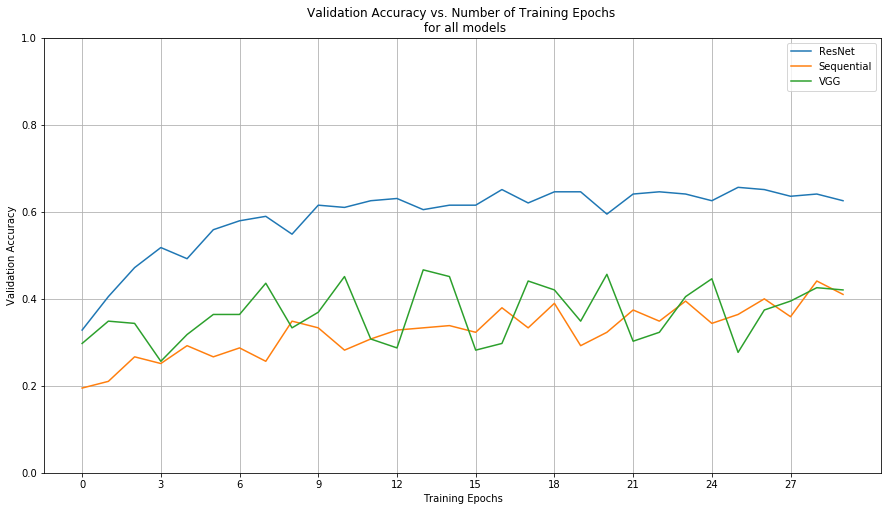

In [14]:
#plot the diagram of validation accuracy for all models
plt.figure(figsize=(15,8))
plt.title("Validation Accuracy vs. Number of Training Epochs \n for all models")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.ylim((0,1.))
plt.plot(np.arange(len(best_model_stats[res_net][1])),best_model_stats[res_net][1],label=res_net.__class__.__name__)
plt.plot(np.arange(len(best_model_stats[model_NN_dense][1])),best_model_stats[model_NN_dense][1],label=model_NN_dense.__class__.__name__)
plt.plot(np.arange(len(best_model_stats[vgg16][1])),best_model_stats[vgg16][1],label=vgg16.__class__.__name__)
plt.grid()
plt.xticks(np.arange(0,len(val_acc_history),3))
plt.legend()
plt.show()

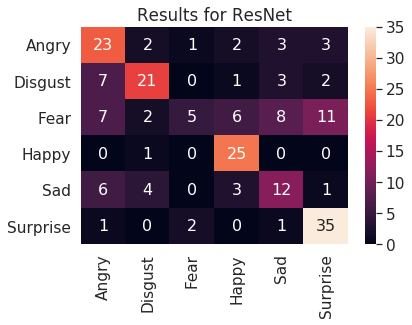

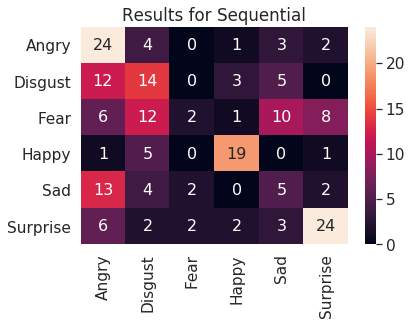

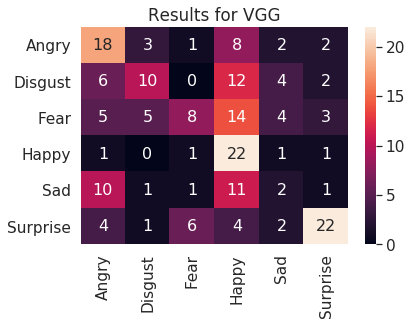

In [0]:
#Present the confusion matrix for each model
target_names=list(dataloaders_dict['test'].dataset.class_to_idx.keys())
for result in results:
  temp=results[result]
  #code for ploting beatiful confusion matrix taken by https://stackoverflow.com/a/42265865/7938716
  df_cm = pd.DataFrame(confusion_matrix(temp['labels'],temp['predictions']), target_names, target_names)
  sn.set(font_scale=1.4) # for label size
  plt.title("Results for %s"%result.__class__.__name__)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  plt.show()
  print("\n\n\n")

The confusion matrix shows us the number of predictions for each class and also the predicted classes for the mispredictions. Using the confusion matrix we can spot the common mistakes made by classifier and understand why these might happen. "Sad" is the most common misprediction. The class that is usually confused with is "Fear". This is intuitive, especially for "Fear" as usually when someone is "Sad" is also feared. On the other hand class Fear is usually confused with Surprise and Angry and not Sad, which is intriguing. 
More specifically for the ResNet model the most accurate class is Happy. It has a F1 score of close to 79% . The second best class is Surprise  with a F1 score 77%. <br/> Similar observations are applied for the simple  model. We can see again that Sad gets confused with Fear. Another common observation is the misprediction of Surprised with Fear, for all models.
<br/>
As we can see in the test set, Happy and Sad have the lowest percentage in the test distribution, with each 26 out of 198 examples, roughly 13%. We can deduce that since since the ResNet is able to find Happy emotion with F1 score equal to 79% and Sad equal to 45%, our model is not good at finding Sad emotion.

As said earlier the train distibution is really well balanced (all classes nears 16-17%). Thus the network should have been able to classify all emotions - expressions correct. As the results are not really close, we can say that some emotion are more easy to classify/discriminate than others. Furthermore, as some emotions are really alike the model cannot always find the correct. Lets remember that this is difficult and ambigous for a human also.


The main metric that is the most important for this scenario and in general for classification is accuracy. Especially in our task, as our classes are well balanced, the accuracy will depict a very good sense of the model's quality. Moreover, as we do not care much about either for False negative or False positive (i.e we are not classifing cancer etc that might have a severe consequence if False negative), recall and precision are not that important. None the less F1 score combined with accuracy can tell us exaclty what we need. The usefulness of recall and precision comes in handy when we want to identify which individual classes have done well and which not, in order to identify their mispredictions through the confusion matrix.

For the ResNet we achieve an accuracy of 61% on the test data. On the simple model we can got to 44% and on Vgg 41%. In general the accuracy is not that high and it demonstrates the problem's difficulty and ambiguity. 

As we can see the best model out of the three is ResNet, then the simple model with one hidden layer and last the Vgg. One would expect that the Vgg model would be first or second. 
One reason VGG is not as good as the ResNet is that it has less layers . ResNet has 50 layer but Vgg has 16. By having more layers ResNet is able to capture more complex distribution and extract more complex and powerful features. This is the main problem we can justify this difference in accuracy between these models. Theoretically, if they were more data and maybe if we added an extra linear layer on top of the last,we should be able to make massive progress concerning accuracy on Vgg. 
Never the less, other reasons that might cause this difference are the data each model was pretrained. Although in the literature both seemed to have been tested using the ImageNet as said in [4] and [5], it is not clear on which dataset these specific weights have been trained on. 

In [0]:
#Statistics and metric about the result of the test set
for result in results:
  print("Results for %s"%result.__class__.__name__)
  print()
  temp=results[result]
  print(classification_report(temp['labels'],temp['predictions'],target_names=target_names))
  print()

Results for ResNet

              precision    recall  f1-score   support

       Angry       0.52      0.68      0.59        34
     Disgust       0.70      0.62      0.66        34
        Fear       0.62      0.13      0.21        39
       Happy       0.68      0.96      0.79        26
         Sad       0.44      0.46      0.45        26
    Surprise       0.67      0.90      0.77        39

    accuracy                           0.61       198
   macro avg       0.61      0.62      0.58       198
weighted avg       0.61      0.61      0.57       198


Results for Sequential

              precision    recall  f1-score   support

       Angry       0.39      0.71      0.50        34
     Disgust       0.34      0.41      0.37        34
        Fear       0.33      0.05      0.09        39
       Happy       0.73      0.73      0.73        26
         Sad       0.19      0.19      0.19        26
    Surprise       0.65      0.62      0.63        39

    accuracy                    

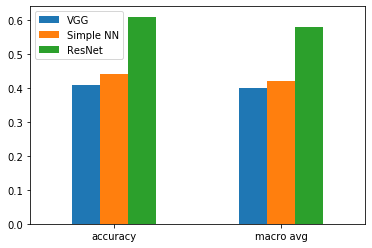

In [0]:
#In this table we can see the relative performance of the most important metrics.

results_table={"Vgg":{'accuracy':0.41,'macro avg':0.40},"Simple NN":{'accuracy':0.44,'macro avg':0.42},"ResNet":{'accuracy':0.61,'macro avg':0.58}}
vgg_results=[0.41,0.40]
nn_results=[0.44,0.42]
res_results=[0.61,0.58]
index = ['accuracy','macro avg']
df = pd.DataFrame({'VGG': vgg_results,
                   'Simple NN': nn_results,"ResNet":res_results}, index=index)
ax = df.plot.bar(rot=0)

We can observe that the accuracy of our best model - ResNet is not that high. As we discussed this is because of the problem difficulty and also the dataset size as it is relatively small. None the less, we wanted to try and find more about the problem, so we tried to make the problem easier by using less classes to classify. <br/>
We tested ResNet with 2, 3, 4 and 5 classes to compare each with the result we got using all classes. We did not try all possible combinations of 2,3 etc classes as this would require many time to produce. We also added the tests with the "Augmented data" (with faces on 45 degrees angles as stated earlier). The results - mainly precision, recall, f1 and accuracy are presented in the next images for each test done.

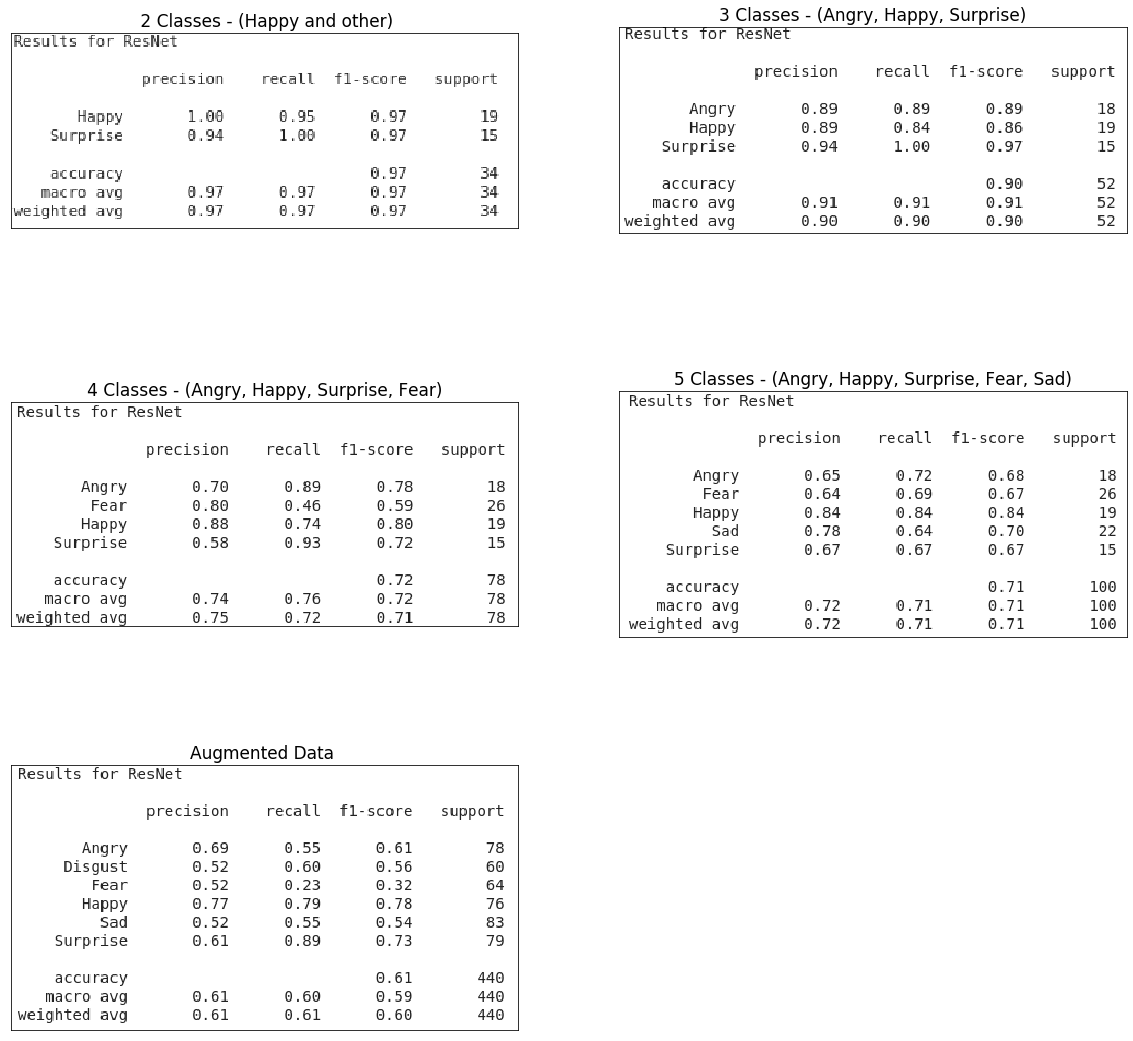

In [0]:
#Here we show some images from our dataset and their correspond label.
plt.figure(figsize=(20,20))
titles=[" 2 Classes - (Happy and other)","3 Classes - (Angry, Happy, Surprise)",
        "4 Classes - (Angry, Happy, Surprise, Fear)","5 Classes - (Angry, Happy, Surprise, Fear, Sad)","Augmented Data "]
links=["https://gitlab.com/Georgios.Hadjiharalambous/data_dl_facial_exressions_ttv_755/-/raw/master/res/happy_surprise.png",
       "https://gitlab.com/Georgios.Hadjiharalambous/data_dl_facial_exressions_ttv_755/-/raw/master/res/3_class.png",
       "https://gitlab.com/Georgios.Hadjiharalambous/data_dl_facial_exressions_ttv_755/-/raw/master/res/4_classes.png",
       "https://gitlab.com/Georgios.Hadjiharalambous/data_dl_facial_exressions_ttv_755/-/raw/master/res/5_class.png",
       "https://gitlab.com/Georgios.Hadjiharalambous/data_dl_facial_exressions_ttv_755/-/raw/master/res/augmented.png"]

for i in range(len(links)):
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img=imread(links[i])
    plt.imshow(img)
    plt.title(titles[i],size=17)
plt.show()

From the results above, we can see that as we add more classes the model is unable to keep the good results - accuracy achieved. On one hand this is intuitive that it will happen as we make our problem harder. Although the drop in accuracy with each addition is big. When we introduced "Angry" class from 2 to 3 classes, the results should not have fallen that much. Especially for he specific emotion the difference between (Angry-Happy and Angry-Surprise)is visible and distiguishable for the human. Another big drop is visible when we go from 3 to 4 classes by adding Fear. Fear as it is very closely related to anger is acceptable that it will impact strongly the results. From the addition of Fear a drop of close to 20% in accuracy is observed. None the less given enough epochs to train,the model should be able to reach close to the accuracy we had before the addition of extra classes. This is not the case and we can blame both the dataset and the problem itself as explained before.

Above we also provide the results for the Augmented data for pure comparison with the current dataset used. A quick note that, here by Augmented data we mean the extra images taken from the KDEF dataset, which were at an angle from the camera. We used these images to enrich our dataset and make it more robust.
The results we got have not really improved but neither gotten worse. Thus we cannot really deduce a specific behaviour as additional investigation is necessary. One thing of course to keep in mind that the dataset of the Augmented data, is a couple times bigger than the original and so given more examples it should have gave better results. In contrast the results stayed about the same range. This can be associated with the fact that the extra images added do not cover - show the whole face of the person. 

The results above can be replicated by changing the number_of_classes to the corresponding number and by uncommenting the corresponding link to download the correct data for each and then running the whole notebook.


Another test we wanted to perform was to transform all of our images into gray scale instead of RGB. The hypothesis behind this is that the characteristics we care about classifying emotions are not colour dependent. The colour in the images might bias the model towards the wrong direction and in general provide wrong information. Never the less, as the pretrained model is trained on RGB images and their inputs that cannot change require an RGB image(i.e 3 dimensions) , this was not done. We tried to do this, but the technique behind this(i.e replicating 3 times the gray scale image to fit an RGB image) was not convincing enought and so we abandomed this test. (The code for this part is left for future trials.)

The problem we are trying to solve is hard for these models to solve it and probably the solution to achieve higher accuracy is to build a new model from scratch. This might be more appropriate as the specific problem is very specific on which areas to look at in order find the correct features/characteristics to classify the image correct. This is where the pretrained models lack a bit, as they are trained to recognize specific features present in all images in general and by fine tuning the last layer it is not good enought for our task. Another idea would be to use an extra layer above the last one in order to capture more complex combination of characteristis. These ideas and problems, are things that we want to try in the future. To sum everything up, after many experiments done currently the best model we used is the ResNet with the last layer trained for the classification task.

#REFERENCES
1.   https://en.wikipedia.org/wiki/Facial_Action_Coding_System

2.   The Extended Cohn-Kanade Dataset (CK+): A complete dataset for action unit and emotion-specified expression

3. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
4. Deep Residual Learning for Image Recognition [https://arxiv.org/pdf/1512.03385.pdf]
5. VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION [https://arxiv.org/pdf/1409.1556.pdf]
